# Computing resources

In [1]:
from dask.distributed import Client
import multiprocessing

ncpu = multiprocessing.cpu_count()
threads = 8
nworker = ncpu // threads
print(
    f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}"
)

Number of CPUs: 48, number of threads: 8, number of workers: 6


In [2]:
client = Client(
    processes=True, threads_per_worker=threads, n_workers=nworker, memory_limit="256GB"
)
client

<Client: 'tcp://127.0.0.1:43520' processes=6 threads=48, memory=402.65 GB>

# Methodology

This script calculates the skill score of Reichler and Kim (2008), but not using all variables. Variables used:
- zonal mean air temperature
- 2m temperature
- precip
- zonal mean winds
- TOA radiation
- surface pressure

We need the timemean varibles on every grid point for every model. These are subtracted by observations on every grid point. We will use ERA5 for this stored on my local work directory: /work/mh0066/m300577/era5/. To do the subtraction, we will interpolate all models to a 2x2 degrees grid.
we also need the interannual variance of every variable, but only for the observations.
After subtracting and using the the interannula variance of normalising, we sum over all gridpoints.
the result is normalised with the average error from are reference model ensemble (CMIP5 AMIP experiments)
A final single index for every model can be obtained by averaging over all variables.

ERA5 cover the whole AMIP timescale. Here we have data mainly for the troposphere, until 50hPa. Therefore all the models are cut off at 50hPa to have consistent vertical levels.

If we use CMIP5 models as reference ensemble in equation (2) of Reichler and Kim, then an index of > 1 tells us that one model is on average worse than CMIP5 models. We do this for every single CMIP5 model and for the ICON tuning experiments. Therefore, we should only think about dismissing one ICON experiment, if it is outside the spread of CMIP5 models.

Data we need:

- CMIP5 models
- ERA5
- ICON tuning experiments

We import the CMIP5 models with the intake-esm module. This should be done on the compute nodes.
ERA5 and ICON are imported with xarray.


# Variables

In [3]:

# for CMIP5 and ICON

vars_2d=['ps', 'rsdt', 'rsut', 'rlut', 'pr', 'tas']
vars_3d=['ta', 'ua', 'va']


variables= vars_2d + vars_3d




- ta : air temperature
- ua : zonal wind
- va : meridional wind
- ps : surface pressure
- pr : precipitation
- tas : near surface air temperature, also 2M temp as it says here: https://cera-www.dkrz.de/WDCC/ui/cerasearch/codes?type=IPCC_DDC_AR5
- rsut : TOA outgoing shortwave radiation
- rlut : TOA outgoing LW radiation
- rsdt : TOA solar insolation

We want net TOA shortwave radiation, since this is given by ERA5 as TSR. For that we subtract rsut from rsdt further below.

# Packages

In [4]:
import intake
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake_esm
import pprint
#import xgcm
import xesmf as xe
import os


print(intake_esm.__version__)
print(xr.__version__)

2020.12.18
0.16.2


# ERA5
This is needed as sigma in equation (2)
ERA5 data are preprocessed to be yearmeans

ERA5 data was downloaded with a cdsapi client, see more here: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels-monthly-means?tab=form
with inspiration from: https://wiki.mpimet.mpg.de/doku.php?id=analysis:data:reanalysis

Informations on the format and units of the variables are here:
https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Monthlymeans


There should be a download_era5 python script somewhere.


In [5]:
era5_2d_file = '../data/era5/era5_2dvars_ym_1979-2014.nc'
era5_3d_file = '../data/era5/era5_3dvars_ym_1979-2014.nc'

era5_2d_ym = xr.open_dataset(era5_2d_file, chunks={'time':35})
era5_3d_ym_all = xr.open_dataset(era5_3d_file, chunks={'time':35})
era5_3d_ym = era5_3d_ym_all[['T', 'U', 'V']]

## Spatial Interpolation
horizontal interpolation to 2x2 grid and vetical interpolation (?)

In [6]:
# use xESMF:

# define ouptut grid
ds_out = xr.Dataset({
                    'lat': (['lat'], np.arange(-89, 90, 2.0)),
                    'lon': (['lon'], np.arange(1, 360, 2.0)),
                    }
                    )

# xesfm needs to have dimensions in certain order
era5_2d_ym_=era5_2d_ym.drop_dims('bnds').transpose('time','lat', 'lon')


regridder = xe.Regridder(era5_2d_ym_, ds_out, 'bilinear', periodic=True, reuse_weights=True)
# for large grids, liek the ERA5, we need to spefify this:
# (https://github.com/JiaweiZhuang/xESMF/issues/71)
regridder._grid_in = None
regridder._grid_out = None

era5_2d_interpol_xe = regridder(era5_2d_ym_)


Reuse existing file: bilinear_721x1440_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable T2M as the horizontal dimensions for this dataset.


/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [7]:


regridder = xe.Regridder(era5_3d_ym, ds_out, 'bilinear', periodic=True, reuse_weights=True)
regridder._grid_in = None
regridder._grid_out = None

era5_3d_interpol_xe = regridder(era5_3d_ym)


Reuse existing file: bilinear_721x1440_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable T as the horizontal dimensions for this dataset.


/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [8]:
%time era5_3d_interpol_xe = era5_3d_interpol_xe.compute()

CPU times: user 1.71 s, sys: 573 ms, total: 2.29 s
Wall time: 21.5 s


## zonal means of 3d vars

In [9]:
era5_3d_zonal_mean_ = era5_3d_interpol_xe.mean('lon')
#select vertical levels we want:
levels=[100000, 85000, 70000, 60000, 50000, 30000, 25000, 20000, 15000, 10000, 5000]

era5_3d_zonal_mean = era5_3d_zonal_mean_.sel(plev=levels)


## Rename Variables

In [10]:
# Variables are renamed to correspond to CMIP5 data
# the radiation varibles are renamed completly to make them less confusing

era5_2d_interpol_xe = era5_2d_interpol_xe.rename(T2M='tas', TP='pr', SP='ps', TTR='TOA_net_LW', TSR='TOA_net_SW')
era5_3d_zonal_mean = era5_3d_zonal_mean.rename(T='ta', U='ua', V='va')


## Calculate the correct units for the variables

https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Monthlymeans

- Radiation needs to be divided by 86400 seconds (24 hours) to convert to the commonly used units of Wm-2.
    - TTR : Top thermal radiation corresponds to rlut in CMIP5 (sign is switched though)
    - TSR : TOA net solar radiation, so Insolation - outgoing solar (CMIP5 : rsdt - rsut)
    
    
- Precipitation TP

    - Is given in [m] as total precipitation (more specifically [m per day] accoring to ERA5 website)
    - multiply by 1000 to get $ kg m^{-2} day^{-1} $
    - divide by 86400 to get $ kg m^{-2} s^{-1} $
    - Then we have the same units as CMIP5

In [11]:
era5_2d_ym

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 721, lon: 1440, time: 36)
Coordinates:
  * time       (time) datetime64[ns] 1979-06-16 1980-06-16 ... 2014-06-16
  * lon        (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat        (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(35, 2), meta=np.ndarray>
    T2M        (time, lat, lon) float32 dask.array<chunksize=(35, 721, 1440), meta=np.ndarray>
    SP         (time, lat, lon) float32 dask.array<chunksize=(35, 721, 1440), meta=np.ndarray>
    SI         (time, lat, lon) float32 dask.array<chunksize=(35, 721, 1440), meta=np.ndarray>
    TSR        (time, lat, lon) float32 dask.array<chunksize=(35, 721, 1440), meta=np.ndarray>
    TTR        (time, lat, lon) float32 dask.array<chunksize=(35, 721, 1440), meta=np.ndarray>
    TP         (time, lat, lon) float32 dask.array<chunksize=(35, 721, 1440), meta=np.ndarray>
Attributes:
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    Conventions:    CF-1.6
    history:        Fri Feb 12 14:56:53 2021: cdo -f nc4 -t ecmwf yearmean /w...
    _NCProperties:  version=2,netcdf=4.6.2,hdf5=1.10.4
    institution:    European Centre for Medium-Range Weather Forecasts
    frequency:      year
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...

In [12]:
era5_2d_interpol_xe['pr'] = era5_2d_interpol_xe.pr/86.4
era5_2d_interpol_xe['TOA_net_LW'] = era5_2d_interpol_xe.TOA_net_LW / -86400.
era5_2d_interpol_xe['TOA_net_SW'] = era5_2d_interpol_xe.TOA_net_SW / 86400.

In [13]:
era5_2d_interpol_xe

<xarray.Dataset>
Dimensions:     (lat: 90, lon: 180, time: 36)
Coordinates:
  * time        (time) datetime64[ns] 1979-06-16 1980-06-16 ... 2014-06-16
  * lon         (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * lat         (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Data variables:
    tas         (time, lat, lon) float64 dask.array<chunksize=(35, 90, 180), meta=np.ndarray>
    ps          (time, lat, lon) float64 dask.array<chunksize=(35, 90, 180), meta=np.ndarray>
    SI          (time, lat, lon) float64 dask.array<chunksize=(35, 90, 180), meta=np.ndarray>
    TOA_net_SW  (time, lat, lon) float64 dask.array<chunksize=(35, 90, 180), meta=np.ndarray>
    TOA_net_LW  (time, lat, lon) float64 dask.array<chunksize=(35, 90, 180), meta=np.ndarray>
    pr          (time, lat, lon) float64 dask.array<chunksize=(35, 90, 180), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Interannual variance
This is used as sigma in equation (1)

This is standard deviation, so we have to square it below

In [14]:
era5_2d_std = era5_2d_interpol_xe.std(dim='time')
era5_3d_std = era5_3d_zonal_mean.std(dim='time')


## Timemean
Is used as o in equation 1

In [15]:
era5_2d_timemean = era5_2d_interpol_xe.mean(dim='time')
era5_3d_timemean = era5_3d_zonal_mean.mean(dim='time')

## Some plots

In [16]:
era5_2d_timemean = era5_2d_timemean.compute()

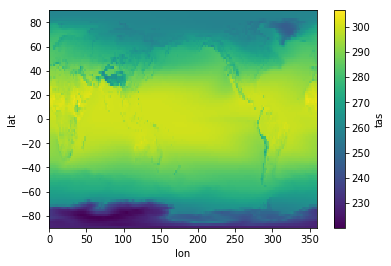

In [17]:
era5_2d_timemean.tas.plot(x='lon',y='lat')

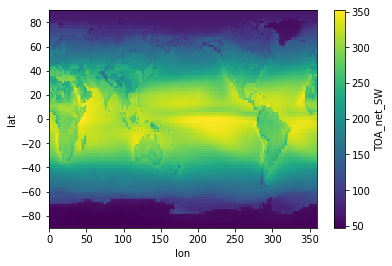

In [18]:
era5_2d_timemean.TOA_net_SW.plot(x='lon',y='lat')

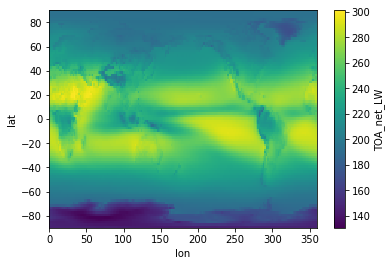

In [19]:
era5_2d_timemean.TOA_net_LW.plot(x='lon',y='lat')

# CMIP6 models
we start with CMIP6, since we need them for the reference error (eq 2 in Reichler and Kim)

we use intake-esm for cmip6 data

The reading of all CMIP5 models and the interpolation takes some time. If you have done this before, the e2 (eq 1 in Reichler and Kim) has been stored as nc file. You can skip the processing of the models by jumping directly to step 5.7.

## Read Data with intake

In [20]:
# available catalogs: combination of .json and .csv
#!/home/mpim/m300524/intake-esm-datastore/catalogs/

In [21]:
col_url = "/work/ik1017/Catalogs/mistral-cmip6.json"
col = intake.open_esm_datastore(col_url)
col.df.head()

activity_id institution_id source_id experiment_id member_id table_id  \
0  AerChemMIP            BCC  BCC-ESM1    hist-piAer  r1i1p1f1   AERmon   
1  AerChemMIP            BCC  BCC-ESM1    hist-piAer  r1i1p1f1   AERmon   
2  AerChemMIP            BCC  BCC-ESM1    hist-piAer  r1i1p1f1   AERmon   
3  AerChemMIP            BCC  BCC-ESM1    hist-piAer  r1i1p1f1   AERmon   
4  AerChemMIP            BCC  BCC-ESM1    hist-piAer  r1i1p1f1   AERmon   

  variable_id grid_label  dcpp_init_year    version     time_range  \
0        c2h6         gn             NaN  v20200511  185001-201412   
1        c3h6         gn             NaN  v20200511  185001-201412   
2        c3h8         gn             NaN  v20200511  185001-201412   
3        cdnc         gn             NaN  v20200522  185001-201412   
4    ch3coch3         gn             NaN  v20200511  185001-201412   

                                                path  \
0  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...   
1  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...   
2  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...   
3  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...   
4  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...   

                                         opendap_url  
0  http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...  
1  http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...  
2  http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...  
3  http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...  
4  http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...

### Selection

#### Variables




- ta : air temperature
- ua : zonal wind
- va : meridional wind
- ps : surface pressure
- pr : precipitation
- tas : near surface air temperature, also 2M temp as it says here: https://cera-www.dkrz.de/WDCC/ui/cerasearch/codes?type=IPCC_DDC_AR5
- rsut : TOA outgoing shortwave radiation
- rlut : TOA outgoing LW radiation
- rsdt : TOA solar insolation

We want net TOA shortwave radiation, since this is given by ERA5 as TSR. For that we subtract rsut from rsdt further below.

#### Query

In [22]:

# require all on makes sure that only models are read which have al variables

query = dict(
    
    activity_id="CMIP",
    experiment_id="amip",
    member_id="r1i1p1f1",
    variable_id=variables,
    table_id="Amon",
    require_all_on = "source_id"

)
cat = col.search(**query)
cat.df.head()

activity_id institution_id   source_id experiment_id member_id table_id  \
0        CMIP   CSIRO-ARCCSS  ACCESS-CM2          amip  r1i1p1f1     Amon   
1        CMIP   CSIRO-ARCCSS  ACCESS-CM2          amip  r1i1p1f1     Amon   
2        CMIP   CSIRO-ARCCSS  ACCESS-CM2          amip  r1i1p1f1     Amon   
3        CMIP   CSIRO-ARCCSS  ACCESS-CM2          amip  r1i1p1f1     Amon   
4        CMIP   CSIRO-ARCCSS  ACCESS-CM2          amip  r1i1p1f1     Amon   

  variable_id grid_label  dcpp_init_year    version     time_range  \
0          pr         gn             NaN  v20191108  197901-201412   
1          ps         gn             NaN  v20191108  197901-201412   
2        rlut         gn             NaN  v20191108  197901-201412   
3        rsdt         gn             NaN  v20191108  197901-201412   
4        rsut         gn             NaN  v20191108  197901-201412   

                                                path  \
0  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...   
1  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...   
2  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...   
3  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...   
4  /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...   

                                         opendap_url  
0  http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...  
1  http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...  
2  http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...  
3  http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...  
4  http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...

In [23]:
cat.df['source_id']

0       ACCESS-CM2
1       ACCESS-CM2
2       ACCESS-CM2
3       ACCESS-CM2
4       ACCESS-CM2
           ...    
1393       TaiESM1
1394       TaiESM1
1395       TaiESM1
1396       TaiESM1
1397       TaiESM1
Name: source_id, Length: 1398, dtype: object

In [25]:
Tai=col.search(
    **dict(
    source_id='TaiESM1',
    activity_id="CMIP",
    experiment_id="amip",
    member_id="r1i1p1f1",
    variable_id="pr",
    table_id="Amon",
))

In [26]:
# wrong paths with wrong versions!

In [27]:
pathlist=list(Tai.df["path"])
pathlist[0]

'/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMIP/AS-RCEC/TaiESM1/amip/r1i1p1f1/Amon/pr/gn/v20200817/pr_Amon_TaiESM1_amip_r1i1p1f1_gn_197901-201012.nc'

In [28]:
pathlist=list(Tai.df["path"])
#pathlist.pop(3) #removes element no 3
pathlist.sort() #to have it in chronological order
for ele in pathlist :
    print(ele)

/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMIP/AS-RCEC/TaiESM1/amip/r1i1p1f1/Amon/pr/gn/v20200817/pr_Amon_TaiESM1_amip_r1i1p1f1_gn_197901-201012.nc
/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMIP/AS-RCEC/TaiESM1/amip/r1i1p1f1/Amon/pr/gn/v20200817/pr_Amon_TaiESM1_amip_r1i1p1f1_gn_201101-201412.nc


In [29]:
def preproc(ds):
    if 'bnds' in ds.dims :
        ds = ds.drop_dims('bnds')
    if 'lat_bnds' in ds :
        ds = ds.drop('lat_bnds')
    if 'lon_bnds' in ds :
        ds = ds.drop('lon_bnds')
    if 'time_bounds' in ds :
        ds = ds.drop('time_bounds')
    if 'nbnd' in ds.dims :
        ds = ds.drop_dims('nbnd')
        
    ds = ds.sel(time=~ds.get_index("time").duplicated())
    #https://stackoverflow.com/questions/51058379/drop-duplicate-times-in-xarray
    
    return ds



- BCC-CSM2-MR: file is not here: /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMIP/BCC/BCC-CSM2-MR/amip/r1i1p1f1/Amon/pr/gn/v20190121/pr_Amon_BCC-CSM2-MR_amip_r1i1p1f1_gn_197901-201412.nc, but here: /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMIP/BCC/BCC-CSM2-MR/amip/r1i1p1f1/Amon/pr/gn/v20200720/pr_Amon_BCC-CSM2-MR_amip_r1i1p1f1_gn_197901-201412.nc

- same here: /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMIP/AS-RCEC/TaiESM1/amip/r1i1p1f1/Amon/pr/gn/v20200817

- /mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMIP/CAS/CAS-ESM2-0/amip/r1i1p1f1/Amon/rsdt/gn/v20200303/rsdt_Amon_CAS-ESM2-0_amip_r1i1p1f1_gn_197801-201412.nc

### Create dictonary and get data

In [30]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={"chunks": {"time": 20}},preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


### Preprocessing: timemean and interpolation

The problem is of course that all models have different grids, so they can't be loadad into one dataset...
Therefore we go through each model and interpolate it to a 2x2 grid and collect the vertical levels needed:



In [31]:
dset_dict.keys()

dict_keys(['CMIP.CAMS.CAMS-CSM1-0.amip.Amon.gn', 'CMIP.MRI.MRI-ESM2-0.amip.Amon.gn', 'CMIP.CMCC.CMCC-CM2-SR5.amip.Amon.gn', 'CMIP.CSIRO-ARCCSS.ACCESS-CM2.amip.Amon.gn', 'CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.amip.Amon.gn', 'CMIP.NUIST.NESM3.amip.Amon.gn', 'CMIP.CAS.FGOALS-f3-L.amip.Amon.gr', 'CMIP.NCAR.CESM2.amip.Amon.gn', 'CMIP.BCC.BCC-CSM2-MR.amip.Amon.gn', 'CMIP.NIMS-KMA.KACE-1-0-G.amip.Amon.gr', 'CMIP.BCC.BCC-ESM1.amip.Amon.gn', 'CMIP.CSIRO.ACCESS-ESM1-5.amip.Amon.gn', 'CMIP.NOAA-GFDL.GFDL-AM4.amip.Amon.gr1', 'CMIP.NCAR.CESM2-WACCM.amip.Amon.gn', 'CMIP.THU.CIESM.amip.Amon.gr', 'CMIP.CCCma.CanESM5.amip.Amon.gn', 'CMIP.MIROC.MIROC6.amip.Amon.gn', 'CMIP.INM.INM-CM4-8.amip.Amon.gr1', 'CMIP.MPI-M.MPI-ESM1-2-LR.amip.Amon.gn', 'CMIP.INM.INM-CM5-0.amip.Amon.gr1', 'CMIP.IPSL.IPSL-CM6A-LR.amip.Amon.gr', 'CMIP.NCAR.CESM2-WACCM-FV2.amip.Amon.gn', 'CMIP.NCC.NorCPM1.amip.Amon.gn', 'CMIP.AS-RCEC.TaiESM1.amip.Amon.gn', 'CMIP.NCAR.CESM2-FV2.amip.Amon.gn', 'CMIP.CCCR-IITM.IITM-ESM.amip.Amon.gn', 'C

In [32]:
# define ouptut grid
ds_out = xr.Dataset({
                    'lat': (['lat'], np.arange(-89, 90, 2.0)),
                    'lon': (['lon'], np.arange(1, 360, 2.0)),
                    })

In [33]:
levels

[100000, 85000, 70000, 60000, 50000, 30000, 25000, 20000, 15000, 10000, 5000]

In [34]:
model_list = []
ds_2d_list = []
ds_3d_list = []

all_levels = [100000., 92500., 85000., 70000., 60000., 50000., 40000., 30000., 25000.,
                20000.,  15000.,  10000., 7000., 5000., 3000., 2000., 1000., 500., 100.]

for key, value in dset_dict.items():

    ds = dset_dict[key].squeeze()
    
    model = ds.source_id
    print(model)
    print(ds.lat)
    model_list.append(model)
    # select time: One model (GFDL-AM4) has missing times in 1979, therfore we chose 1980-2014:
    ds = ds.sel(time=slice('1980-01-01','2014-12-30'))
    
    # timemean and select vertical levels:
    #for some models (ACCESS) the plev coordinate is weird. Therefore:
    ds['plev'] = all_levels
    ds = ds.sel(plev=levels)
    ds_timmean = ds.mean('time')
    #print(ds_timmean)
    
    if "height" in ds_timmean.coords :
        ds_timmean = ds_timmean.drop('height')

    # 2d and 3d data:
    ds_2d = ds_timmean.drop_vars(vars_3d)
    ds_3d = ds_timmean.drop_vars(vars_2d)
    
    # interpolation
    regridder = xe.Regridder(ds_2d, ds_out, 'bilinear', periodic=True, reuse_weights=True)
    regridder._grid_in = None
    regridder._grid_out = None

    ds_2d_interpol = regridder(ds_2d)
    ds_2d_list.append(ds_2d_interpol)
    
    regridder = xe.Regridder(ds_3d, ds_out, 'bilinear', periodic=True, reuse_weights=True)
    regridder._grid_in = None
    regridder._grid_out = None
    
    ds_3d_interpol = regridder(ds_3d)
    ds_3d_list.append(ds_3d_interpol)
     
    print("        ")


CAMS-CSM1-0
<xarray.DataArray 'lat' (lat: 160)>
array([-89.141519, -88.029429, -86.910771, -85.790629, -84.669924, -83.548947,
       -82.427818, -81.306595, -80.18531 , -79.063982, -77.942624, -76.821243,
       -75.699844, -74.578432, -73.457008, -72.335576, -71.214136, -70.09269 ,
       -68.97124 , -67.849784, -66.728326, -65.606864, -64.485399, -63.363932,
       -62.242462, -61.120991, -59.999518, -58.878044, -57.756569, -56.635092,
       -55.513614, -54.392135, -53.270655, -52.149175, -51.027694, -49.906212,
       -48.784729, -47.663246, -46.541763, -45.420279, -44.298794, -43.177309,
       -42.055824, -40.934338, -39.812852, -38.691366, -37.56988 , -36.448393,
       -35.326906, -34.205418, -33.083931, -31.962443, -30.840955, -29.719467,
       -28.597979, -27.476491, -26.355002, -25.233514, -24.112025, -22.990536,
       -21.869047, -20.747558, -19.626069, -18.50458 , -17.383091, -16.261601,
       -15.140112, -14.018622, -12.897133, -11.775643, -10.654153,  -9.532664,
    

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_160x320_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
MRI-ESM2-0
<xarray.DataArray 'lat' (lat: 160)>
array([-89.14152, -88.02943, -86.91077, -85.79063, -84.66992, -83.54895,
       -82.42782, -81.30659, -80.18531, -79.06398, -77.94262, -76.82124,
       -75.69984, -74.57843, -73.45701, -72.33558, -71.21414, -70.09269,
       -68.97124, -67.84978, -66.72833, -65.60686, -64.4854 , -63.36393,
       -62.24246, -61.12099, -59.99952, -58.87804, -57.75657, -56.63509,
       -55.51361, -54.39214, -53.27066, -52.14917, -51.02769, -49.90621,
       -48.78473, -47.66325, -46.54176, -45.42028, -44.29879, -43.17731,
       -42.05582, -40.93434, -39.81285, -38.69137, -37.56988, -36.44839,
       -35.32691, -34.20542, -33.08393, -31.96244, -30.84096, -29.71947,
       -28.59798, -27.47649, -26.355  , -25.23351, -24.11203, -22.99054,
       -21.86905, -20.74756, -19.62607, -18.50458, -17.38309

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


        
CMCC-CM2-SR5
<xarray.DataArray 'lat' (lat: 192)>
array([-90.      , -89.057592, -88.115183, -87.172775, -86.230366, -85.287958,
       -84.34555 , -83.403141, -82.460733, -81.518325, -80.575916, -79.633508,
       -78.691099, -77.748691, -76.806283, -75.863874, -74.921466, -73.979058,
       -73.036649, -72.094241, -71.151832, -70.209424, -69.267016, -68.324607,
       -67.382199, -66.439791, -65.497382, -64.554974, -63.612565, -62.670157,
       -61.727749, -60.78534 , -59.842932, -58.900524, -57.958115, -57.015707,
       -56.073298, -55.13089 , -54.188482, -53.246073, -52.303665, -51.361257,
       -50.418848, -49.47644 , -48.534031, -47.591623, -46.649215, -45.706806,
       -44.764398, -43.82199 , -42.879581, -41.937173, -40.994764, -40.052356,
       -39.109948, -38.167539, -37.225131, -36.282723, -35.340314, -34.397906,
       -33.455497, -32.513089, -31.570681, -30.628272, -29.685864, -28.743455,
       -27.801047, -26.858639, -25.91623 , -24.973822, -24.031414, -23.08

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_192x288_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
ACCESS-CM2
<xarray.DataArray 'lat' (lat: 289)>
array([-90.   , -89.375, -88.75 , ...,  88.75 ,  89.375,  90.   ])
Coordinates:
  * lat        (lat) float64 -90.0 -89.38 -88.75 -88.12 ... 88.75 89.38 90.0
    member_id  <U8 'r1i1p1f1'
    height     float64 ...
Attributes:
    bounds:         lat_bnds
    units:          degrees_north
    axis:           Y
    long_name:      Latitude
    standard_name:  latitude
Reuse existing file: bilinear_289x384_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_289x384_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
MPI-ESM-1-2-HAM
<xarray.DataArray 'lat' (lat: 96)>
array([-88.572169, -86.722531, -84.86197 , -82.998942, -81.134977, -79.270559,
       -77.405888, -75.541061, -73.676132, -71.811132, -69.946081, -68.080991,
       -66.215872, -64.35073 , -62.485571, -60.620396, -58.755209, -56.890013,
       -55.024808, -53.159595, -51.294377, -49.429154, -47.563926, -45.698694,
       -43.833459, -41.96822 , -40.102979, -38.237736, -36.372491, -34.507243,
       -32.641994, -30.776744, -28.911492, -27.046239, -25.180986, -23.315731,
       -21.450475, -19.585219, -17.719962, -15.854704, -13.989446, -12.124187,
       -10.258928,  -8.393669,  -6.528409,  -4.66315 ,  -2.79789 ,  -0.93263 ,
         0.93263 ,   2.79789 ,   4.66315 ,   6.528409,   8.393669,  10.258928,
        12.124187,  13.989446,  15.854704,  17.719962,  19.585219,  21.4504

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_96x192_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
NESM3
<xarray.DataArray 'lat' (lat: 96)>
array([-88.572166, -86.722527, -84.861969, -82.99894 , -81.134979, -79.270561,
       -77.405891, -75.541061, -73.676132, -71.811127, -69.946083, -68.080994,
       -66.215874, -64.350731, -62.485569, -60.620399, -58.755211, -56.890011,
       -55.024811, -53.159599, -51.29438 , -49.42915 , -47.563931, -45.698689,
       -43.833462, -41.96822 , -40.102982, -38.23774 , -36.37249 , -34.50724 ,
       -32.641991, -30.776739, -28.911489, -27.04624 , -25.18099 , -23.315729,
       -21.45048 , -19.58522 , -17.719959, -15.8547  , -13.98945 , -12.12419 ,
       -10.25893 ,  -8.393669,  -6.528409,  -4.66315 ,  -2.79789 ,  -0.93263 ,
         0.93263 ,   2.79789 ,   4.66315 ,   6.528409,   8.393669,  10.25893 ,
        12.12419 ,  13.98945 ,  15.8547  ,  17.719959,  19.58522 ,  21.45048 ,
       

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_96x192_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
FGOALS-f3-L
<xarray.DataArray 'lat' (lat: 180)>
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_180x288_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.


/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


        
CESM2
<xarray.DataArray 'lat' (lat: 192)>
array([-90.      , -89.057592, -88.115183, -87.172775, -86.230366, -85.287958,
       -84.34555 , -83.403141, -82.460733, -81.518325, -80.575916, -79.633508,
       -78.691099, -77.748691, -76.806283, -75.863874, -74.921466, -73.979058,
       -73.036649, -72.094241, -71.151832, -70.209424, -69.267016, -68.324607,
       -67.382199, -66.439791, -65.497382, -64.554974, -63.612565, -62.670157,
       -61.727749, -60.78534 , -59.842932, -58.900524, -57.958115, -57.015707,
       -56.073298, -55.13089 , -54.188482, -53.246073, -52.303665, -51.361257,
       -50.418848, -49.47644 , -48.534031, -47.591623, -46.649215, -45.706806,
       -44.764398, -43.82199 , -42.879581, -41.937173, -40.994764, -40.052356,
       -39.109948, -38.167539, -37.225131, -36.282723, -35.340314, -34.397906,
       -33.455497, -32.513089, -31.570681, -30.628272, -29.685864, -28.743455,
       -27.801047, -26.858639, -25.91623 , -24.973822, -24.031414, -23.089005,
 

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


        
BCC-CSM2-MR
<xarray.DataArray 'lat' (lat: 160)>
array([-89.141519, -88.029429, -86.910771, -85.790629, -84.669924, -83.548947,
       -82.427818, -81.306595, -80.18531 , -79.063982, -77.942624, -76.821243,
       -75.699844, -74.578432, -73.457008, -72.335576, -71.214136, -70.09269 ,
       -68.97124 , -67.849784, -66.728326, -65.606864, -64.485399, -63.363932,
       -62.242462, -61.120991, -59.999518, -58.878044, -57.756569, -56.635092,
       -55.513614, -54.392135, -53.270655, -52.149175, -51.027694, -49.906212,
       -48.784729, -47.663246, -46.541763, -45.420279, -44.298794, -43.177309,
       -42.055824, -40.934338, -39.812852, -38.691366, -37.56988 , -36.448393,
       -35.326906, -34.205418, -33.083931, -31.962443, -30.840955, -29.719467,
       -28.597979, -27.476491, -26.355002, -25.233514, -24.112025, -22.990536,
       -21.869047, -20.747558, -19.626069, -18.50458 , -17.383091, -16.261601,
       -15.140112, -14.018622, -12.897133, -11.775643, -10.654153,  -9.532

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


        
KACE-1-0-G
<xarray.DataArray 'lat' (lat: 289)>
array([-90.   , -89.375, -88.75 , ...,  88.75 ,  89.375,  90.   ])
Coordinates:
  * lat        (lat) float64 -90.0 -89.38 -88.75 -88.12 ... 88.75 89.38 90.0
    member_id  <U8 'r1i1p1f1'
    height     float64 ...
Attributes:
    bounds:         lat_bnds
    units:          degrees_north
    axis:           Y
    long_name:      Latitude
    standard_name:  latitude
Reuse existing file: bilinear_289x384_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_289x384_90x180_peri.nc


/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
BCC-ESM1
<xarray.DataArray 'lat' (lat: 64)>
array([-87.863799, -85.096527, -82.312913, -79.525607, -76.7369  , -73.947515,
       -71.157752, -68.367756, -65.577607, -62.787352, -59.99702 , -57.206632,
       -54.4162  , -51.625734, -48.835241, -46.044727, -43.254195, -40.463648,
       -37.67309 , -34.882521, -32.091944, -29.30136 , -26.510769, -23.720174,
       -20.929574, -18.138971, -15.348365, -12.557756,  -9.767146,  -6.976534,
        -4.185921,  -1.395307,   1.395307,   4.185921,   6.976534,   9.767146,
        12.557756,  15.348365,  18.138971,  20.929574,  23.720174,  26.510769,
        29.30136 ,  32.091944,  34.882521,  37.67309 ,  40.463648,  43.254195,
        46.044727,  48.835241,  51.625734,  54.4162  ,  57.206632,  59.99702 ,
        62.787352,  65.577607,  68.367756,  71.157752,  73.947515,  76.7369  ,
        79.525607,  82.312913,  85.096527,  87.863799])


/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_64x128_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
ACCESS-ESM1-5
<xarray.DataArray 'lat' (lat: 289)>
array([-90.   , -89.375, -88.75 , ...,  88.75 ,  89.375,  90.   ])
Coordinates:
  * lat        (lat) float64 -90.0 -89.38 -88.75 -88.12 ... 88.75 89.38 90.0
    member_id  <U8 'r1i1p1f1'
    height     float64 ...
Attributes:
    bounds:         lat_bnds
    units:          degrees_north
    axis:           Y
    long_name:      Latitude
    standard_name:  latitude
Reuse existing file: bilinear_289x384_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_289x384_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
GFDL-AM4
<xarray.DataArray 'lat' (lat: 180)>
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x288_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
CESM2-WACCM
<xarray.DataArray 'lat' (lat: 192)>
array([-90.      , -89.057592, -88.115183, -87.172775, -86.230366, -85.287958,
       -84.34555 , -83.403141, -82.460733, -81.518325, -80.575916, -79.633508,
       -78.691099, -77.748691, -76.806283, -75.863874, -74.921466, -73.979058,
       -73.036649, -72.094241, -71.151832, -70.209424, -69.267016, -68.324607,
       -67.382199, -66.439791, -65.497382, -64.554974, -63.612565, -62.670157,
       -61.727749, -60.78534 , -59.842932, -58.900524, -57.958115, -57.015707,
       -56.073298, -55.13089 , -54.188482, -53.246073, -52.303665, -51.361257,
       -50.418848, -49.47644 , -48.534031, -47.591623, -46.649215, -45.706806,
       -44.764398, -43.82199 , -42.879581, -41.937173, -40.994764, -40.052356,
       -39.109948, -38.167539, -37.225131, -36.282723, -35.340314, -34.397906,

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_192x288_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
CIESM
<xarray.DataArray 'lat' (lat: 192)>
array([-90.      , -89.057592, -88.115183, -87.172775, -86.230366, -85.287958,
       -84.34555 , -83.403141, -82.460733, -81.518325, -80.575916, -79.633508,
       -78.691099, -77.748691, -76.806283, -75.863874, -74.921466, -73.979058,
       -73.036649, -72.094241, -71.151832, -70.209424, -69.267016, -68.324607,
       -67.382199, -66.439791, -65.497382, -64.554974, -63.612565, -62.670157,
       -61.727749, -60.78534 , -59.842932, -58.900524, -57.958115, -57.015707,
       -56.073298, -55.13089 , -54.188482, -53.246073, -52.303665, -51.361257,
       -50.418848, -49.47644 , -48.534031, -47.591623, -46.649215, -45.706806,
       -44.764398, -43.82199 , -42.879581, -41.937173, -40.994764, -40.052356,
       -39.109948, -38.167539, -37.225131, -36.282723, -35.340314, -34.397906,
     

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_192x288_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
CanESM5
<xarray.DataArray 'lat' (lat: 64)>
array([-87.863799, -85.096527, -82.312913, -79.525607, -76.7369  , -73.947515,
       -71.157752, -68.367756, -65.577607, -62.787352, -59.99702 , -57.206632,
       -54.4162  , -51.625734, -48.835241, -46.044727, -43.254195, -40.463648,
       -37.67309 , -34.882521, -32.091944, -29.30136 , -26.510769, -23.720174,
       -20.929574, -18.138971, -15.348365, -12.557756,  -9.767146,  -6.976534,
        -4.185921,  -1.395307,   1.395307,   4.185921,   6.976534,   9.767146,
        12.557756,  15.348365,  18.138971,  20.929574,  23.720174,  26.510769,
        29.30136 ,  32.091944,  34.882521,  37.67309 ,  40.463648,  43.254195,
        46.044727,  48.835241,  51.625734,  54.4162  ,  57.206632,  59.99702 ,
        62.787352,  65.577607,  68.367756,  71.157752,  73.947515,  76.7369  ,
    

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_64x128_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
MIROC6
<xarray.DataArray 'lat' (lat: 128)>
array([-88.927735, -87.538705, -86.141472, -84.742386, -83.342596, -81.942466,
       -80.542146, -79.14171 , -77.741196, -76.340629, -74.940023, -73.539389,
       -72.138732, -70.738059, -69.337372, -67.936673, -66.535966, -65.135251,
       -63.73453 , -62.333803, -60.933072, -59.532337, -58.131598, -56.730857,
       -55.330112, -53.929366, -52.528617, -51.127867, -49.727115, -48.326361,
       -46.925606, -45.52485 , -44.124093, -42.723335, -41.322576, -39.921816,
       -38.521056, -37.120294, -35.719532, -34.31877 , -32.918007, -31.517244,
       -30.11648 , -28.715716, -27.314951, -25.914186, -24.513421, -23.112655,
       -21.71189 , -20.311124, -18.910357, -17.509591, -16.108824, -14.708057,
       -13.30729 , -11.906523, -10.505756,  -9.104989,  -7.704221,  -6.303454,
     

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_128x256_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
INM-CM4-8
<xarray.DataArray 'lat' (lat: 120)>
array([-89.25, -87.75, -86.25, -84.75, -83.25, -81.75, -80.25, -78.75, -77.25,
       -75.75, -74.25, -72.75, -71.25, -69.75, -68.25, -66.75, -65.25, -63.75,
       -62.25, -60.75, -59.25, -57.75, -56.25, -54.75, -53.25, -51.75, -50.25,
       -48.75, -47.25, -45.75, -44.25, -42.75, -41.25, -39.75, -38.25, -36.75,
       -35.25, -33.75, -32.25, -30.75, -29.25, -27.75, -26.25, -24.75, -23.25,
       -21.75, -20.25, -18.75, -17.25, -15.75, -14.25, -12.75, -11.25,  -9.75,
        -8.25,  -6.75,  -5.25,  -3.75,  -2.25,  -0.75,   0.75,   2.25,   3.75,
         5.25,   6.75,   8.25,   9.75,  11.25,  12.75,  14.25,  15.75,  17.25,
        18.75,  20.25,  21.75,  23.25,  24.75,  26.25,  27.75,  29.25,  30.75,
        32.25,  33.75,  35.25,  36.75,  38.25,  39.75,  41.25,  42.75,  44.25,
 

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_120x180_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_120x180_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
MPI-ESM1-2-LR
<xarray.DataArray 'lat' (lat: 96)>
array([-88.572169, -86.722531, -84.86197 , -82.998942, -81.134977, -79.270559,
       -77.405888, -75.541061, -73.676132, -71.811132, -69.946081, -68.080991,
       -66.215872, -64.35073 , -62.485571, -60.620396, -58.755209, -56.890013,
       -55.024808, -53.159595, -51.294377, -49.429154, -47.563926, -45.698694,
       -43.833459, -41.96822 , -40.102979, -38.237736, -36.372491, -34.507243,
       -32.641994, -30.776744, -28.911492, -27.046239, -25.180986, -23.315731,
       -21.450475, -19.585219, -17.719962, -15.854704, -13.989446, -12.124187,
       -10.258928,  -8.393669,  -6.528409,  -4.66315 ,  -2.79789 ,  -0.93263 ,
         0.93263 ,   2.79789 ,   4.66315 ,   6.528409,   8.393669,  10.258928,
        12.124187,  13.989446,  15.854704,  17.719962,  19.585219,  21.450475

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_96x192_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
INM-CM5-0
<xarray.DataArray 'lat' (lat: 120)>
array([-89.25, -87.75, -86.25, -84.75, -83.25, -81.75, -80.25, -78.75, -77.25,
       -75.75, -74.25, -72.75, -71.25, -69.75, -68.25, -66.75, -65.25, -63.75,
       -62.25, -60.75, -59.25, -57.75, -56.25, -54.75, -53.25, -51.75, -50.25,
       -48.75, -47.25, -45.75, -44.25, -42.75, -41.25, -39.75, -38.25, -36.75,
       -35.25, -33.75, -32.25, -30.75, -29.25, -27.75, -26.25, -24.75, -23.25,
       -21.75, -20.25, -18.75, -17.25, -15.75, -14.25, -12.75, -11.25,  -9.75,
        -8.25,  -6.75,  -5.25,  -3.75,  -2.25,  -0.75,   0.75,   2.25,   3.75,
         5.25,   6.75,   8.25,   9.75,  11.25,  12.75,  14.25,  15.75,  17.25,
        18.75,  20.25,  21.75,  23.25,  24.75,  26.25,  27.75,  29.25,  30.75,
        32.25,  33.75,  35.25,  36.75,  38.25,  39.75,  41.25,  42.75,  44.25,
  

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_120x180_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
IPSL-CM6A-LR
<xarray.DataArray 'lat' (lat: 143)>
array([-90.      , -88.73239 , -87.46479 , -86.19718 , -84.92958 , -83.66197 ,
       -82.39436 , -81.12676 , -79.85915 , -78.59155 , -77.323944, -76.056335,
       -74.788734, -73.521126, -72.253525, -70.985916, -69.71831 , -68.45071 ,
       -67.1831  , -65.91549 , -64.64789 , -63.380283, -62.112675, -60.84507 ,
       -59.577465, -58.30986 , -57.042255, -55.774647, -54.507042, -53.239437,
       -51.971832, -50.704224, -49.43662 , -48.169014, -46.90141 , -45.633804,
       -44.366196, -43.09859 , -41.830986, -40.56338 , -39.295776, -38.028168,
       -36.760563, -35.492958, -34.225353, -32.957745, -31.690142, -30.422535,
       -29.15493 , -27.887323, -26.619719, -25.352112, -24.084507, -22.816902,
       -21.549295, -20.28169 , -19.014084, -17.746479, -16.478872, -15.211267

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_143x144_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
CESM2-WACCM-FV2
<xarray.DataArray 'lat' (lat: 96)>
array([-90.      , -88.105263, -86.210526, -84.315789, -82.421053, -80.526316,
       -78.631579, -76.736842, -74.842105, -72.947368, -71.052632, -69.157895,
       -67.263158, -65.368421, -63.473684, -61.578947, -59.684211, -57.789474,
       -55.894737, -54.      , -52.105263, -50.210526, -48.315789, -46.421053,
       -44.526316, -42.631579, -40.736842, -38.842105, -36.947368, -35.052632,
       -33.157895, -31.263158, -29.368421, -27.473684, -25.578947, -23.684211,
       -21.789474, -19.894737, -18.      , -16.105263, -14.210526, -12.315789,
       -10.421053,  -8.526316,  -6.631579,  -4.736842,  -2.842105,  -0.947368,
         0.947368,   2.842105,   4.736842,   6.631579,   8.526316,  10.421053,
        12.315789,  14.210526,  16.105263,  18.      ,  19.894737,  21.7894

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_96x144_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
NorCPM1
<xarray.DataArray 'lat' (lat: 96)>
array([-90.      , -88.105263, -86.210526, -84.315789, -82.421053, -80.526316,
       -78.631579, -76.736842, -74.842105, -72.947368, -71.052632, -69.157895,
       -67.263158, -65.368421, -63.473684, -61.578947, -59.684211, -57.789474,
       -55.894737, -54.      , -52.105263, -50.210526, -48.315789, -46.421053,
       -44.526316, -42.631579, -40.736842, -38.842105, -36.947368, -35.052632,
       -33.157895, -31.263158, -29.368421, -27.473684, -25.578947, -23.684211,
       -21.789474, -19.894737, -18.      , -16.105263, -14.210526, -12.315789,
       -10.421053,  -8.526316,  -6.631579,  -4.736842,  -2.842105,  -0.947368,
         0.947368,   2.842105,   4.736842,   6.631579,   8.526316,  10.421053,
        12.315789,  14.210526,  16.105263,  18.      ,  19.894737,  21.789474,
     

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_96x144_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
TaiESM1
<xarray.DataArray 'lat' (lat: 192)>
array([-90.      , -89.057592, -88.115183, -87.172775, -86.230366, -85.287958,
       -84.34555 , -83.403141, -82.460733, -81.518325, -80.575916, -79.633508,
       -78.691099, -77.748691, -76.806283, -75.863874, -74.921466, -73.979058,
       -73.036649, -72.094241, -71.151832, -70.209424, -69.267016, -68.324607,
       -67.382199, -66.439791, -65.497382, -64.554974, -63.612565, -62.670157,
       -61.727749, -60.78534 , -59.842932, -58.900524, -57.958115, -57.015707,
       -56.073298, -55.13089 , -54.188482, -53.246073, -52.303665, -51.361257,
       -50.418848, -49.47644 , -48.534031, -47.591623, -46.649215, -45.706806,
       -44.764398, -43.82199 , -42.879581, -41.937173, -40.994764, -40.052356,
       -39.109948, -38.167539, -37.225131, -36.282723, -35.340314, -34.397906,
    

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_192x288_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
CESM2-FV2
<xarray.DataArray 'lat' (lat: 96)>
array([-90.      , -88.105263, -86.210526, -84.315789, -82.421053, -80.526316,
       -78.631579, -76.736842, -74.842105, -72.947368, -71.052632, -69.157895,
       -67.263158, -65.368421, -63.473684, -61.578947, -59.684211, -57.789474,
       -55.894737, -54.      , -52.105263, -50.210526, -48.315789, -46.421053,
       -44.526316, -42.631579, -40.736842, -38.842105, -36.947368, -35.052632,
       -33.157895, -31.263158, -29.368421, -27.473684, -25.578947, -23.684211,
       -21.789474, -19.894737, -18.      , -16.105263, -14.210526, -12.315789,
       -10.421053,  -8.526316,  -6.631579,  -4.736842,  -2.842105,  -0.947368,
         0.947368,   2.842105,   4.736842,   6.631579,   8.526316,  10.421053,
        12.315789,  14.210526,  16.105263,  18.      ,  19.894737,  21.789474,
  

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_96x144_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
IITM-ESM
<xarray.DataArray 'lat' (lat: 94)>
array([-88.54195 , -86.653167, -84.75323 , -82.850772, -80.947359, -79.043483,
       -77.139349, -75.235055, -73.330657, -71.426186, -69.521663, -67.617101,
       -65.712509, -63.807894, -61.90326 , -59.998611, -58.09395 , -56.189279,
       -54.284599, -52.379912, -50.475219, -48.57052 , -46.665817, -44.76111 ,
       -42.856399, -40.951685, -39.046969, -37.14225 , -35.237529, -33.332806,
       -31.428081, -29.523355, -27.618628, -25.7139  , -23.80917 , -21.904439,
       -19.999708, -18.094976, -16.190243, -14.28551 , -12.380776, -10.476042,
        -8.571308,  -6.666573,  -4.761838,  -2.857103,  -0.952368,   0.952368,
         2.857103,   4.761838,   6.666573,   8.571308,  10.476042,  12.380776,
        14.28551 ,  16.190243,  18.094976,  19.999708,  21.904439,  23.80917 ,
    

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_94x192_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
FGOALS-g3
<xarray.DataArray 'lat' (lat: 80)>
array([-90.      , -84.818858, -80.719206, -77.218073, -74.111265, -71.28958 ,
       -68.686492, -66.257912, -63.97284 , -61.808492, -59.746835, -57.721519,
       -55.696203, -53.670886, -51.64557 , -49.620253, -47.594937, -45.56962 ,
       -43.544304, -41.518987, -39.493671, -37.468354, -35.443038, -33.417722,
       -31.392405, -29.367089, -27.341772, -25.316456, -23.291139, -21.265823,
       -19.240506, -17.21519 , -15.189873, -13.164557, -11.139241,  -9.113924,
        -7.088608,  -5.063291,  -3.037975,  -1.012658,   1.012658,   3.037975,
         5.063291,   7.088608,   9.113924,  11.139241,  13.164557,  15.189873,
        17.21519 ,  19.240506,  21.265823,  23.291139,  25.316456,  27.341772,
        29.367089,  31.392405,  33.417722,  35.443038,  37.468354,  39.493671,
   

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_80x180_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.


/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


        
SAM0-UNICON
<xarray.DataArray 'lat' (lat: 192)>
array([-90.      , -89.057592, -88.115183, -87.172775, -86.230366, -85.287958,
       -84.34555 , -83.403141, -82.460733, -81.518325, -80.575916, -79.633508,
       -78.691099, -77.748691, -76.806283, -75.863874, -74.921466, -73.979058,
       -73.036649, -72.094241, -71.151832, -70.209424, -69.267016, -68.324607,
       -67.382199, -66.439791, -65.497382, -64.554974, -63.612565, -62.670157,
       -61.727749, -60.78534 , -59.842932, -58.900524, -57.958115, -57.015707,
       -56.073298, -55.13089 , -54.188482, -53.246073, -52.303665, -51.361257,
       -50.418848, -49.47644 , -48.534031, -47.591623, -46.649215, -45.706806,
       -44.764398, -43.82199 , -42.879581, -41.937173, -40.994764, -40.052356,
       -39.109948, -38.167539, -37.225131, -36.282723, -35.340314, -34.397906,
       -33.455497, -32.513089, -31.570681, -30.628272, -29.685864, -28.743455,
       -27.801047, -26.858639, -25.91623 , -24.973822, -24.031414, -23.089

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


        
NorESM2-LM
<xarray.DataArray 'lat' (lat: 96)>
array([-90.      , -88.105263, -86.210526, -84.315789, -82.421053, -80.526316,
       -78.631579, -76.736842, -74.842105, -72.947368, -71.052632, -69.157895,
       -67.263158, -65.368421, -63.473684, -61.578947, -59.684211, -57.789474,
       -55.894737, -54.      , -52.105263, -50.210526, -48.315789, -46.421053,
       -44.526316, -42.631579, -40.736842, -38.842105, -36.947368, -35.052632,
       -33.157895, -31.263158, -29.368421, -27.473684, -25.578947, -23.684211,
       -21.789474, -19.894737, -18.      , -16.105263, -14.210526, -12.315789,
       -10.421053,  -8.526316,  -6.631579,  -4.736842,  -2.842105,  -0.947368,
         0.947368,   2.842105,   4.736842,   6.631579,   8.526316,  10.421053,
        12.315789,  14.210526,  16.105263,  18.      ,  19.894737,  21.789474,
        23.684211,  25.578947,  27.473684,  29.368421,  31.263158,  33.157895,
        35.052632,  36.947368,  38.842105,  40.736842,  42.631579,  44.52631

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


        
GISS-E2-1-G
<xarray.DataArray 'lat' (lat: 90)>
array([-89., -87., -85., -83., -81., -79., -77., -75., -73., -71., -69., -67.,
       -65., -63., -61., -59., -57., -55., -53., -51., -49., -47., -45., -43.,
       -41., -39., -37., -35., -33., -31., -29., -27., -25., -23., -21., -19.,
       -17., -15., -13., -11.,  -9.,  -7.,  -5.,  -3.,  -1.,   1.,   3.,   5.,
         7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,  23.,  25.,  27.,  29.,
        31.,  33.,  35.,  37.,  39.,  41.,  43.,  45.,  47.,  49.,  51.,  53.,
        55.,  57.,  59.,  61.,  63.,  65.,  67.,  69.,  71.,  73.,  75.,  77.,
        79.,  81.,  83.,  85.,  87.,  89.])
Coordinates:
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    member_id  <U8 'r1i1p1f1'
    height     float64 ...
Attributes:
    bounds:         lat_bnds
    units:          degrees_north
    axis:           Y
    long_name:      latitude
    standard_name:  latitude
Reuse existing file: bilinear_90x144_90x180_p

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_90x144_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
GFDL-CM4
<xarray.DataArray 'lat' (lat: 180)>
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  1

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x288_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
MPI-ESM1-2-HR
<xarray.DataArray 'lat' (lat: 192)>
array([-89.284228, -88.357004, -87.424304, -86.490367, -85.55596 , -84.621327,
       -83.686567, -82.751728, -81.816839, -80.881913, -79.946962, -79.011992,
       -78.077007, -77.142011, -76.207005, -75.271992, -74.336973, -73.401949,
       -72.466921, -71.531889, -70.596854, -69.661816, -68.726776, -67.791734,
       -66.856691, -65.921645, -64.986599, -64.051551, -63.116502, -62.181452,
       -61.246401, -60.311349, -59.376297, -58.441244, -57.50619 , -56.571136,
       -55.636081, -54.701026, -53.76597 , -52.830914, -51.895857, -50.960801,
       -50.025743, -49.090686, -48.155628, -47.22057 , -46.285512, -45.350454,
       -44.415395, -43.480336, -42.545277, -41.610218, -40.675159, -39.740099,
       -38.805039, -37.86998 , -36.93492 , -35.99986 , -35.064799, -34.12973

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_192x384_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
E3SM-1-0
<xarray.DataArray 'lat' (lat: 180)>
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  

/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x360_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
EC-Earth3
<xarray.DataArray 'lat' (lat: 256)>
array([-89.462822, -88.766951, -88.066972, ...,  88.066972,  88.766951,
        89.462822])
Coordinates:
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
    member_id  <U8 'r1i1p1f1'
    height     float64 ...
Attributes:
    bounds:         lat_bnds
    units:          degrees_north
    axis:           Y
    long_name:      Latitude
    standard_name:  latitude
Reuse existing file: bilinear_256x512_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_256x512_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        
EC-Earth3-Veg
<xarray.DataArray 'lat' (lat: 256)>
array([-89.462822, -88.766951, -88.066972, ...,  88.066972,  88.766951,
        89.462822])
Coordinates:
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
    member_id  <U8 'r1i1p1f1'
    height     float64 ...
Attributes:
    bounds:         lat_bnds
    units:          degrees_north
    axis:           Y
    long_name:      Latitude
    standard_name:  latitude
Reuse existing file: bilinear_256x512_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_256x512_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable ta as the horizontal dimensions for this dataset.
        


Concat all datasets to one:

In [35]:
mod_id_ar = xr.DataArray(model_list[:], name='model_id',dims='model_id')

cmip6_2d = xr.concat(ds_2d_list, mod_id_ar)
cmip6_3d = xr.concat(ds_3d_list, mod_id_ar)


In [36]:
%time cmip6_2d = cmip6_2d.compute()

CPU times: user 37.8 s, sys: 1.56 s, total: 39.4 s
Wall time: 1min 9s


In [37]:
%time cmip6_3d = cmip6_3d.compute()

CPU times: user 1min 5s, sys: 4.36 s, total: 1min 10s
Wall time: 5min 37s


Drop some more unneeded things:

In [38]:
#cmip5_2d = cmip5_2d.drop('height').drop('plev')
#cmip5_3d = cmip5_3d.drop('height')

## Zonal means of 3d vars

In [39]:
cmip6_3d_zonmean = cmip6_3d.mean('lon')

## Calculate TOA net SW

In [40]:
cmip6_2d['TOA_net_SW'] = cmip6_2d.rsdt - cmip6_2d.rsut
cmip6_2d = cmip6_2d.rename(rlut='TOA_net_LW')

## Some plots to see if data looks alright

### tas

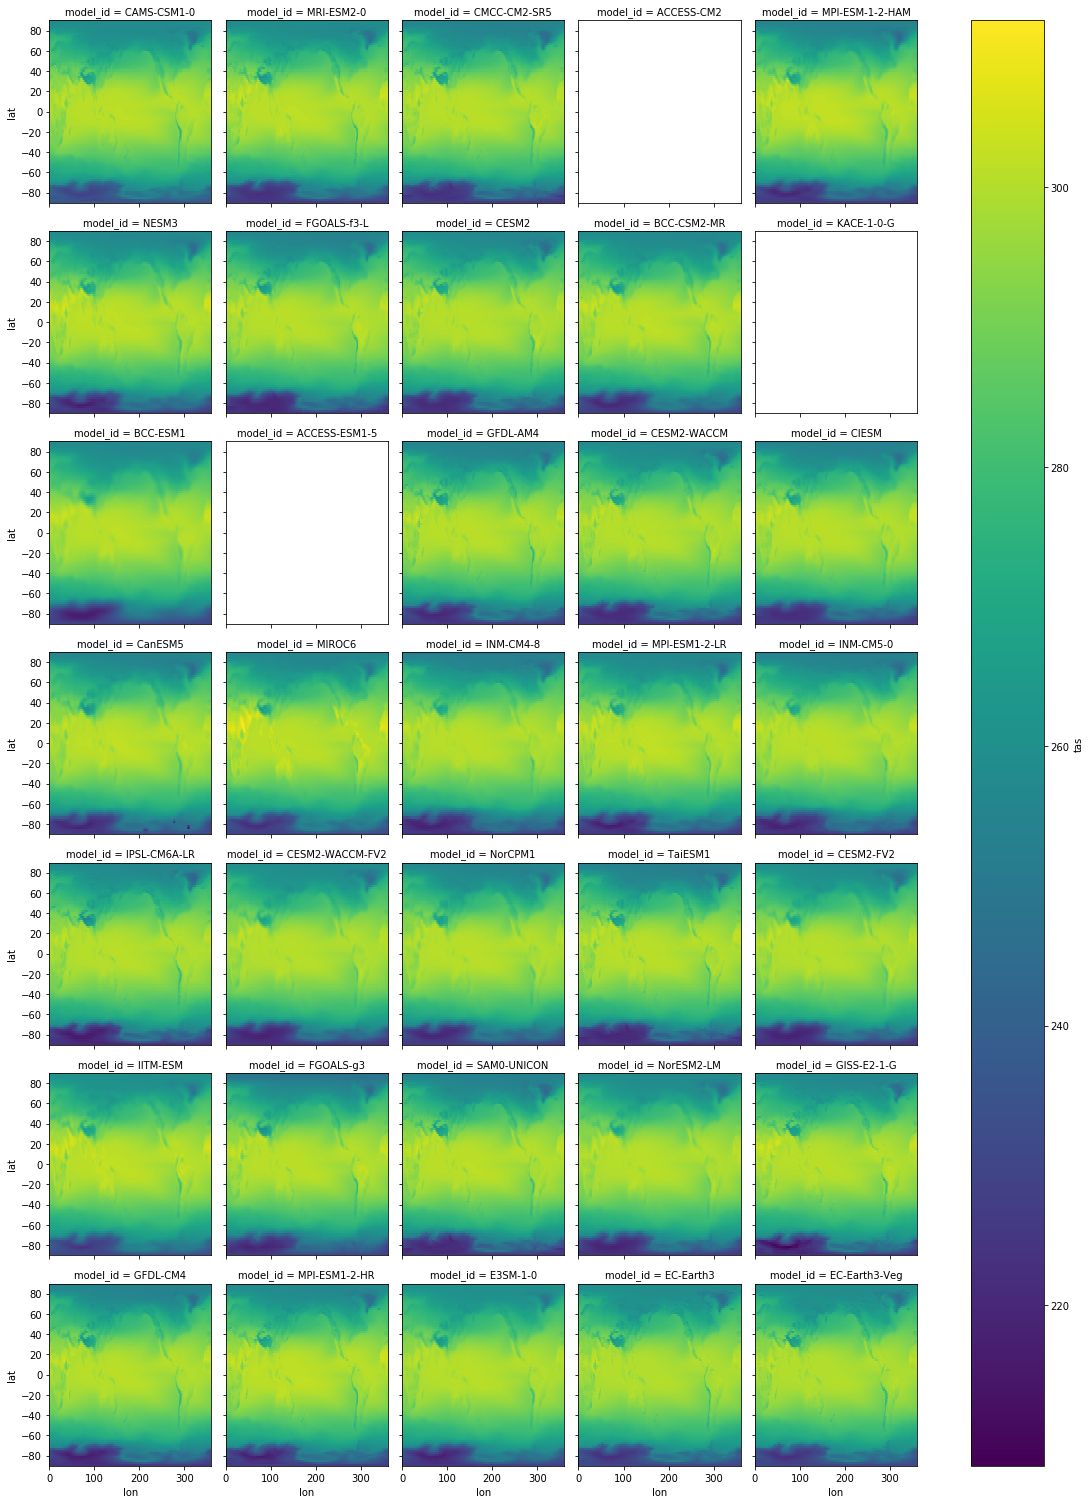

In [41]:
cmip6_2d.tas.plot(x='lon',y='lat',col='model_id', col_wrap=5)

### Precipitation

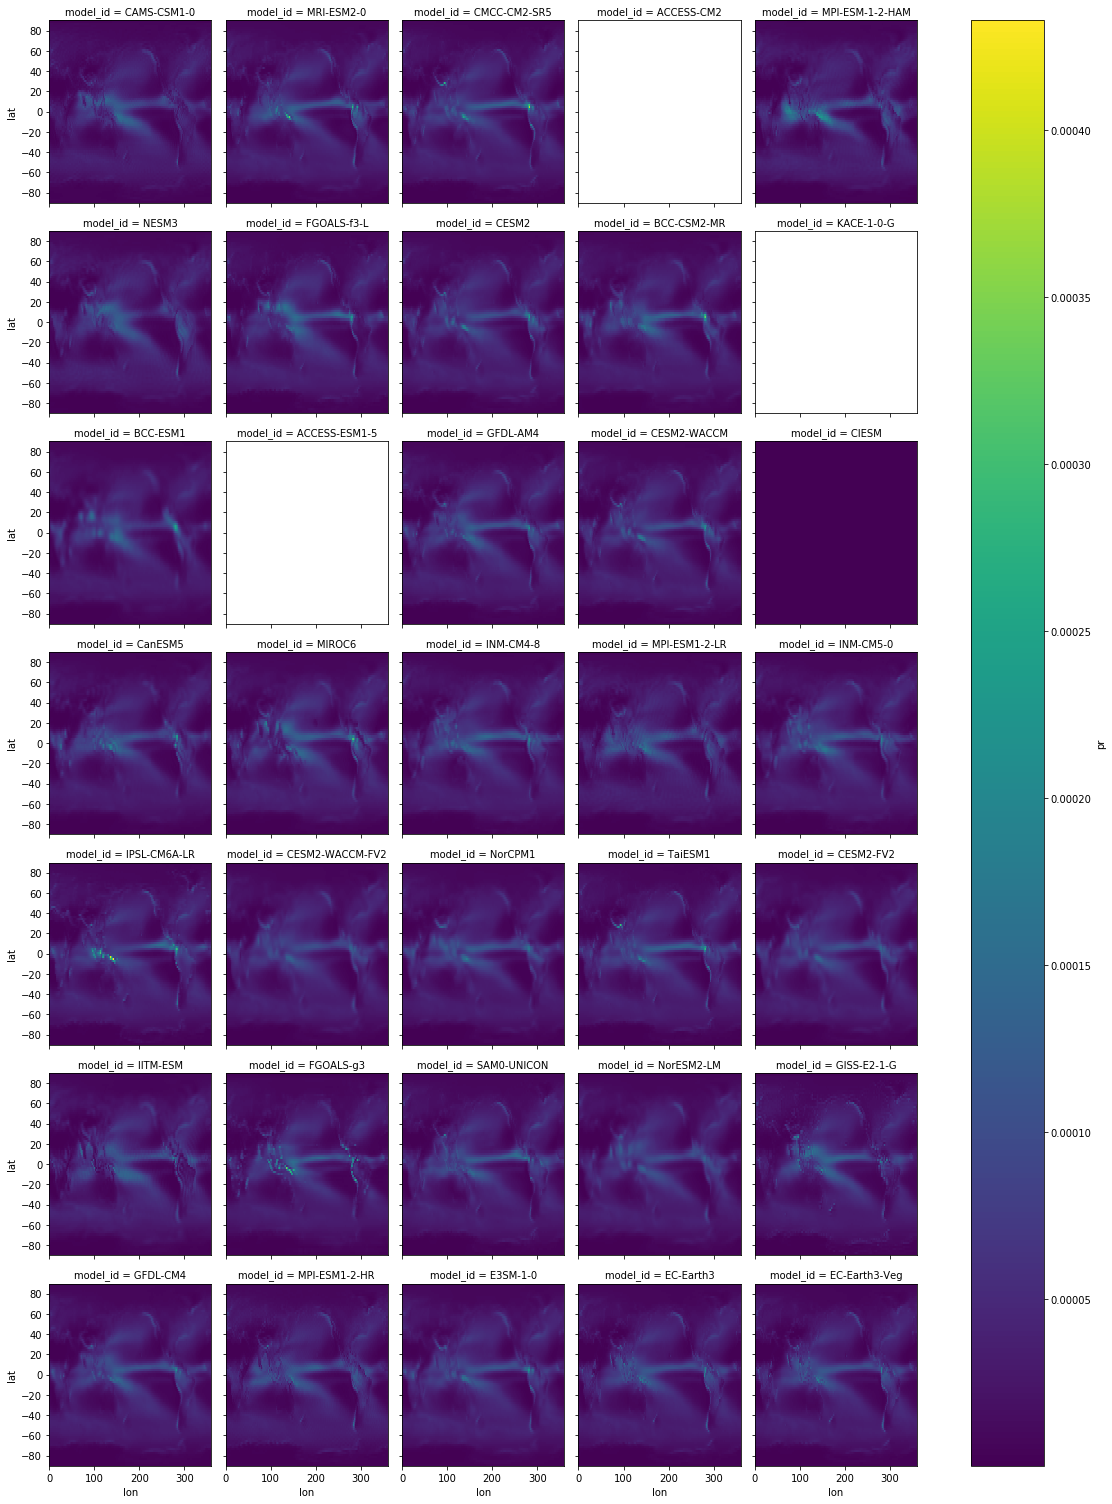

In [42]:
cmip6_2d.pr.plot(x='lon',y='lat',col='model_id', col_wrap=5)

### Surface pressure

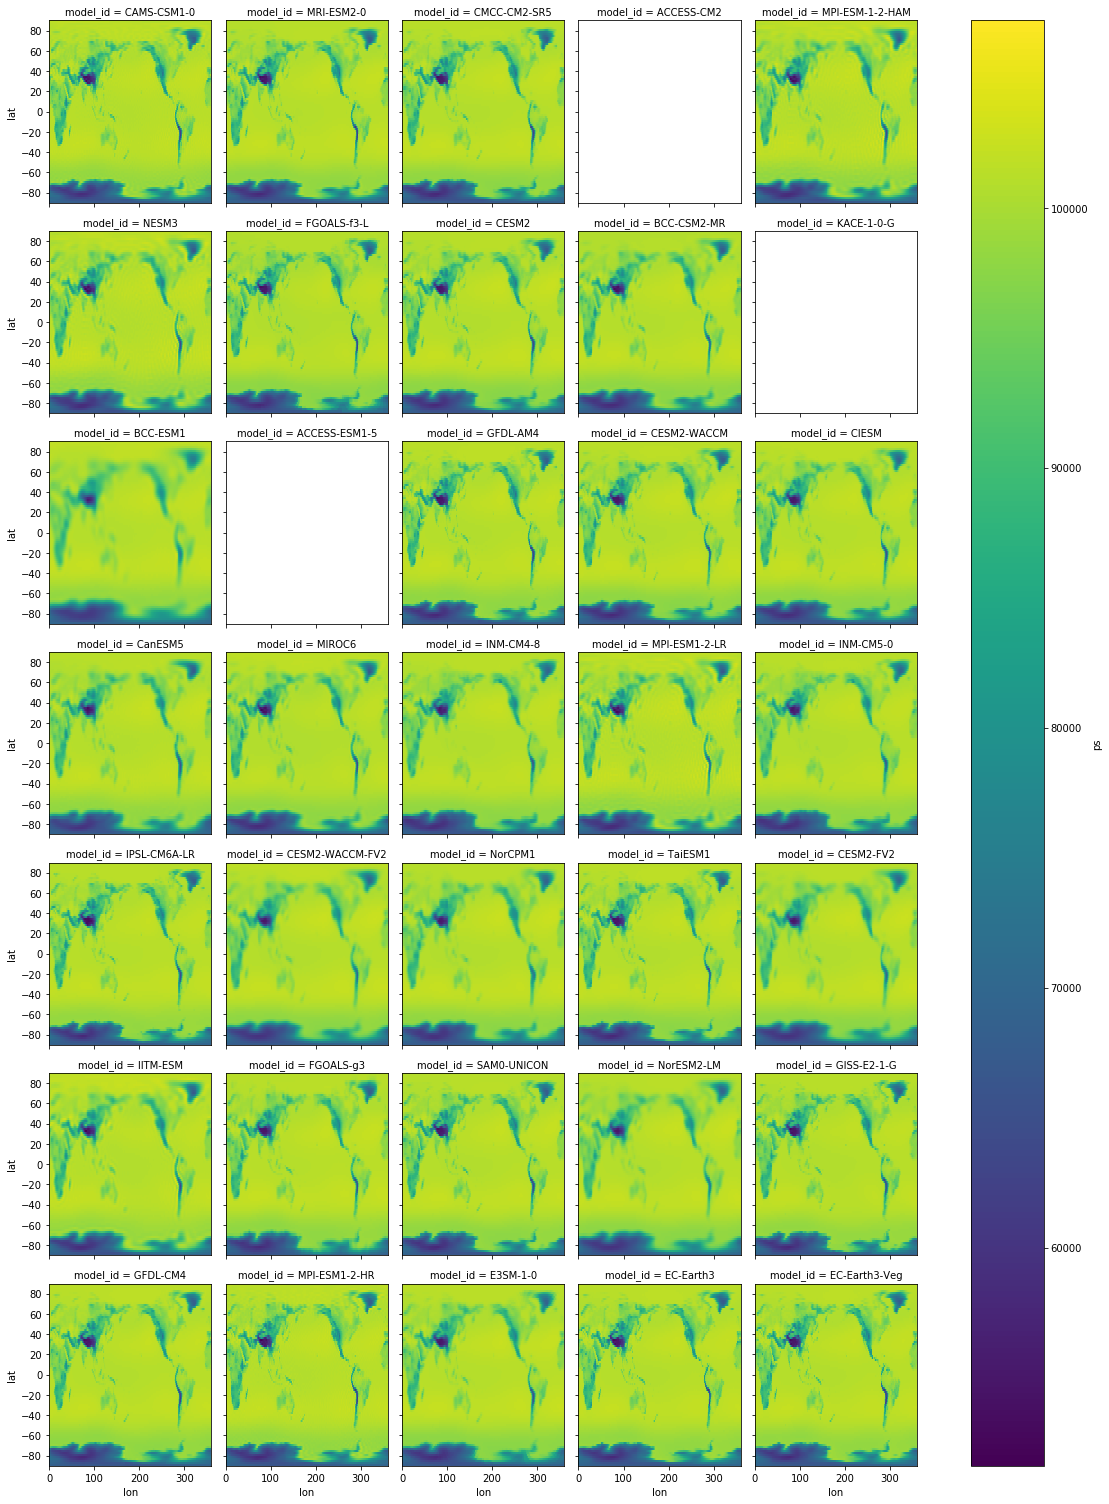

In [43]:
cmip6_2d.ps.plot(x='lon',y='lat',col='model_id', col_wrap=5)

### rsut

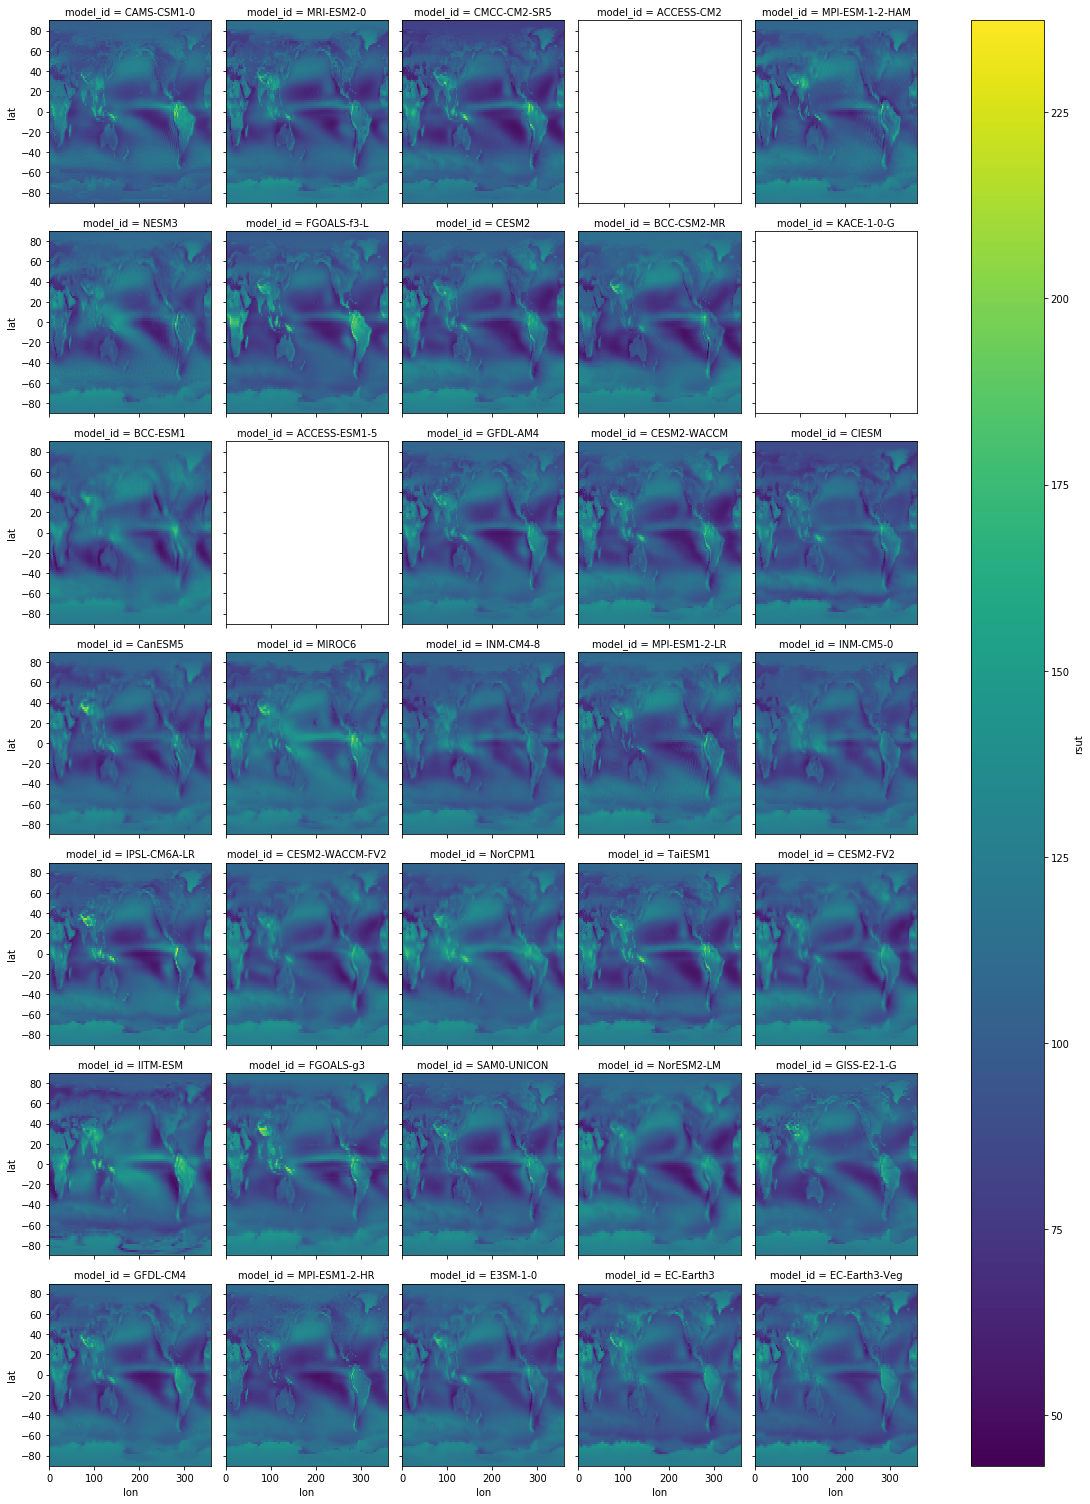

In [44]:
cmip6_2d.rsut.plot(x='lon',y='lat',col='model_id', col_wrap=5)

### TOA net SW

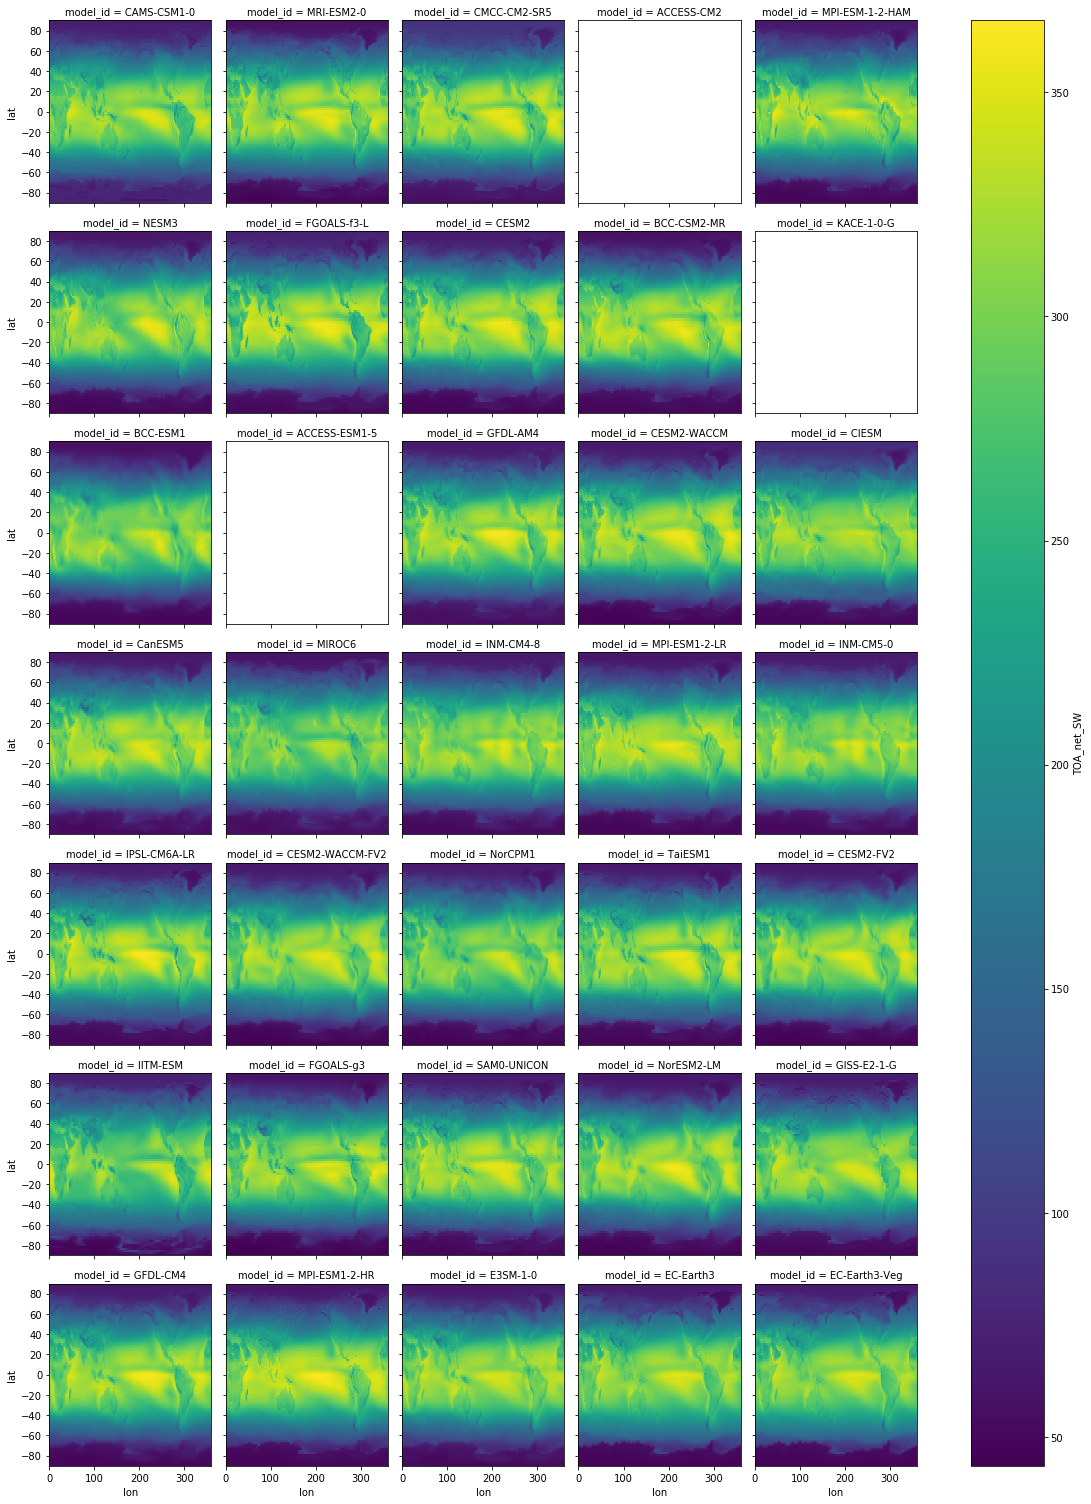

In [45]:
cmip6_2d.TOA_net_SW.plot(x='lon',y='lat',col='model_id', col_wrap=5)

### TOA net LW

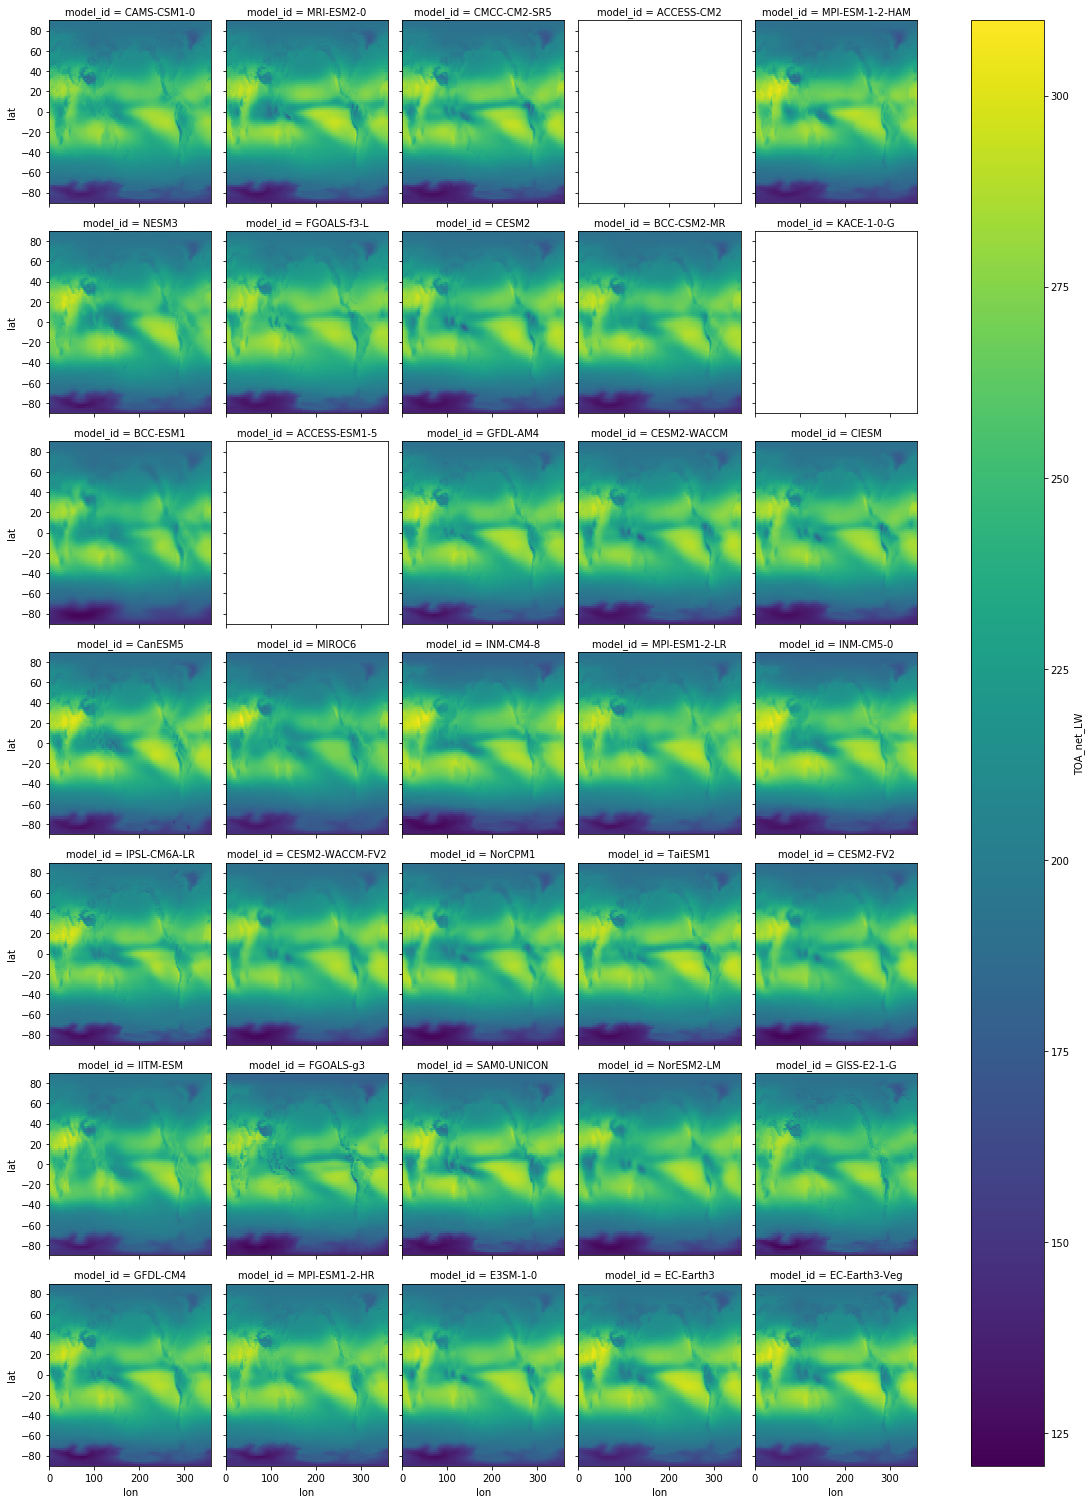

In [46]:
cmip6_2d.TOA_net_LW.plot(x='lon',y='lat',col='model_id', col_wrap=5)

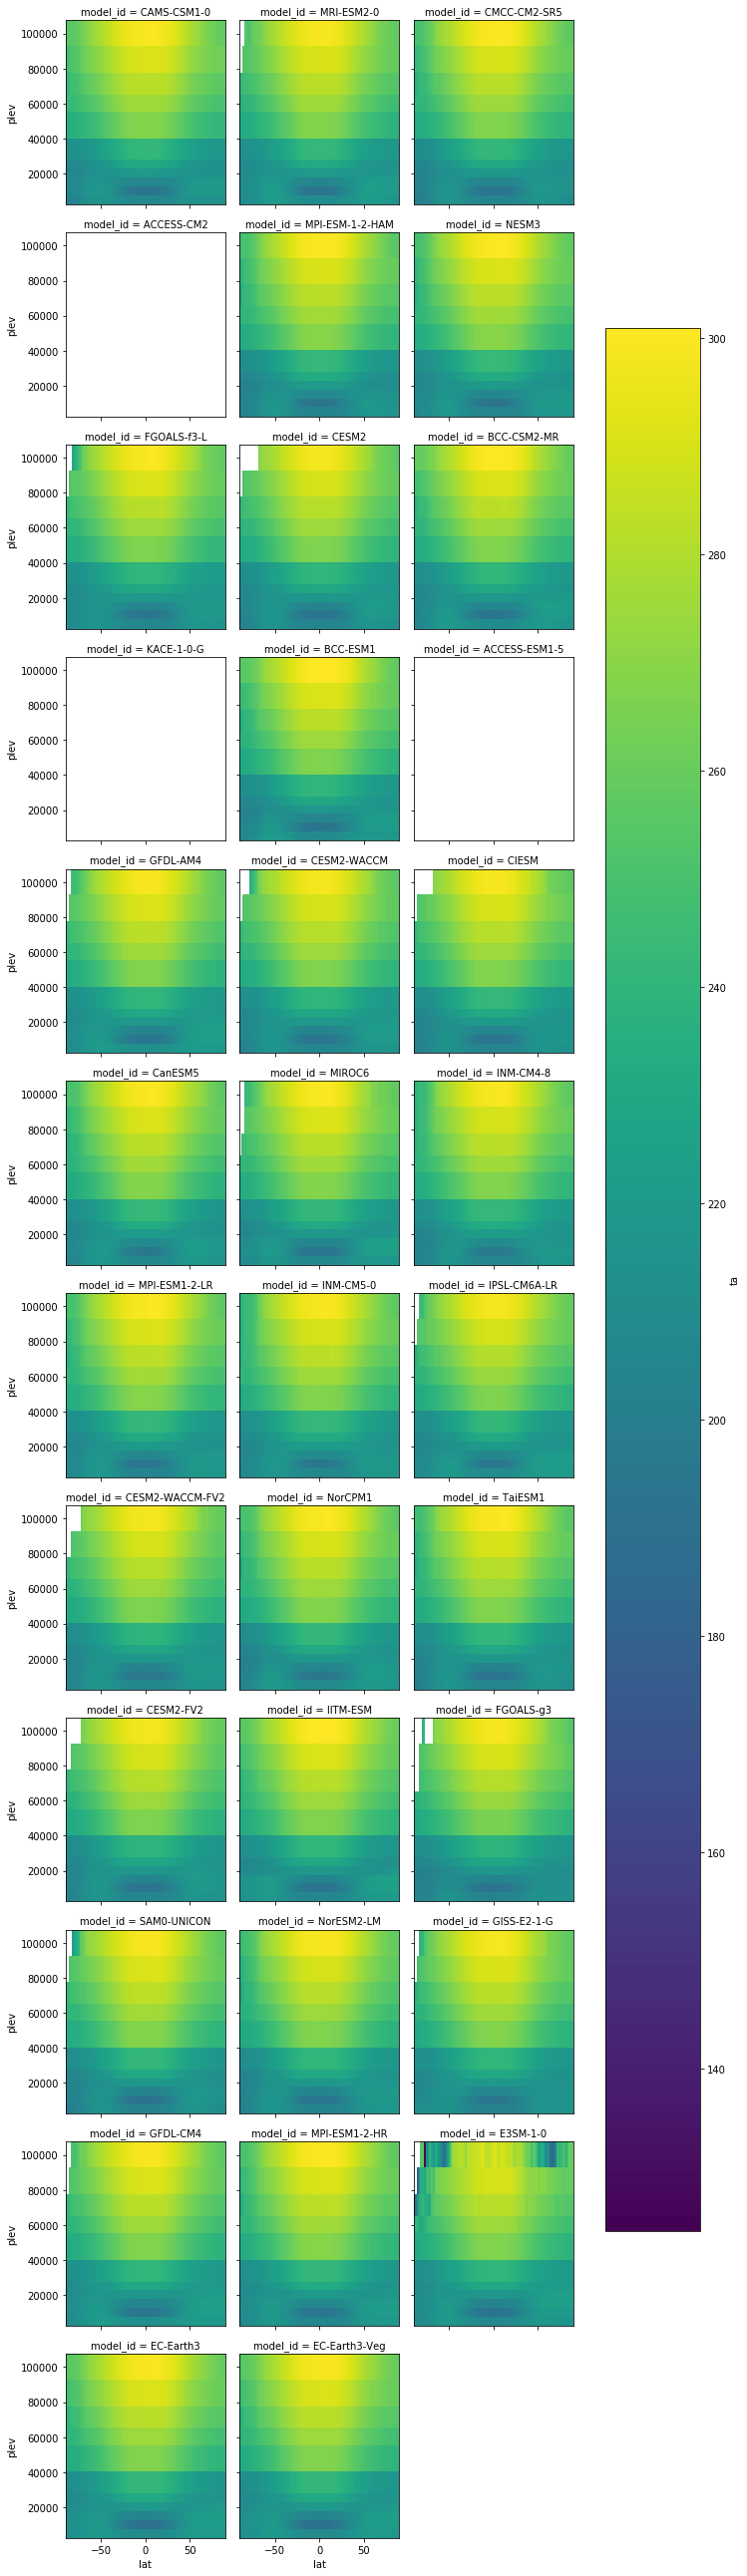

In [47]:
cmip6_3d_zonmean.ta.plot(x='lat',y='plev',col='model_id',col_wrap=3)

## Exclude more models

regridding of the ACCESS models and the KACE models fails, because a large portion of the gridpoints are nans.
We also exclude the E3SM-1-0 model, becasue it has weird 1000hPa ta values

In [48]:

cmip6_2d = cmip6_2d.drop_sel(model_id=['ACCESS-ESM1-5','ACCESS-CM2','KACE-1-0-G','E3SM-1-0'])
cmip6_3d_zonmean = cmip6_3d_zonmean.drop_sel(model_id=['ACCESS-ESM1-5','ACCESS-CM2','KACE-1-0-G','E3SM-1-0'])


## Calculation of e^2 (equation 1)


In [49]:
difference = cmip6_2d - era5_2d_timemean
output_2d = np.square( difference / era5_2d_std )

difference = cmip6_3d_zonmean - era5_3d_timemean
output_3d = np.square( difference / era5_3d_std )


There are some nans, but they are just from the lower levels in cases where the durface pressure is lower than the predefined pressu

In [50]:
output_3d

<xarray.Dataset>
Dimensions:    (lat: 90, model_id: 31, plev: 11)
Coordinates:
    member_id  <U8 'r1i1p1f1'
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 6e+04 ... 1.5e+04 1e+04 5e+03
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * model_id   (model_id) <U15 'CAMS-CSM1-0' 'MRI-ESM2-0' ... 'EC-Earth3-Veg'
Data variables:
    ta         (model_id, plev, lat) float64 63.15 44.99 40.79 ... 2.038 1.984
    ua         (model_id, plev, lat) float64 88.34 28.16 3.76 ... 1.424 1.739
    va         (model_id, plev, lat) float64 161.5 8.91 259.2 ... 0.2022 0.2271

Some of the differences we see are really high!

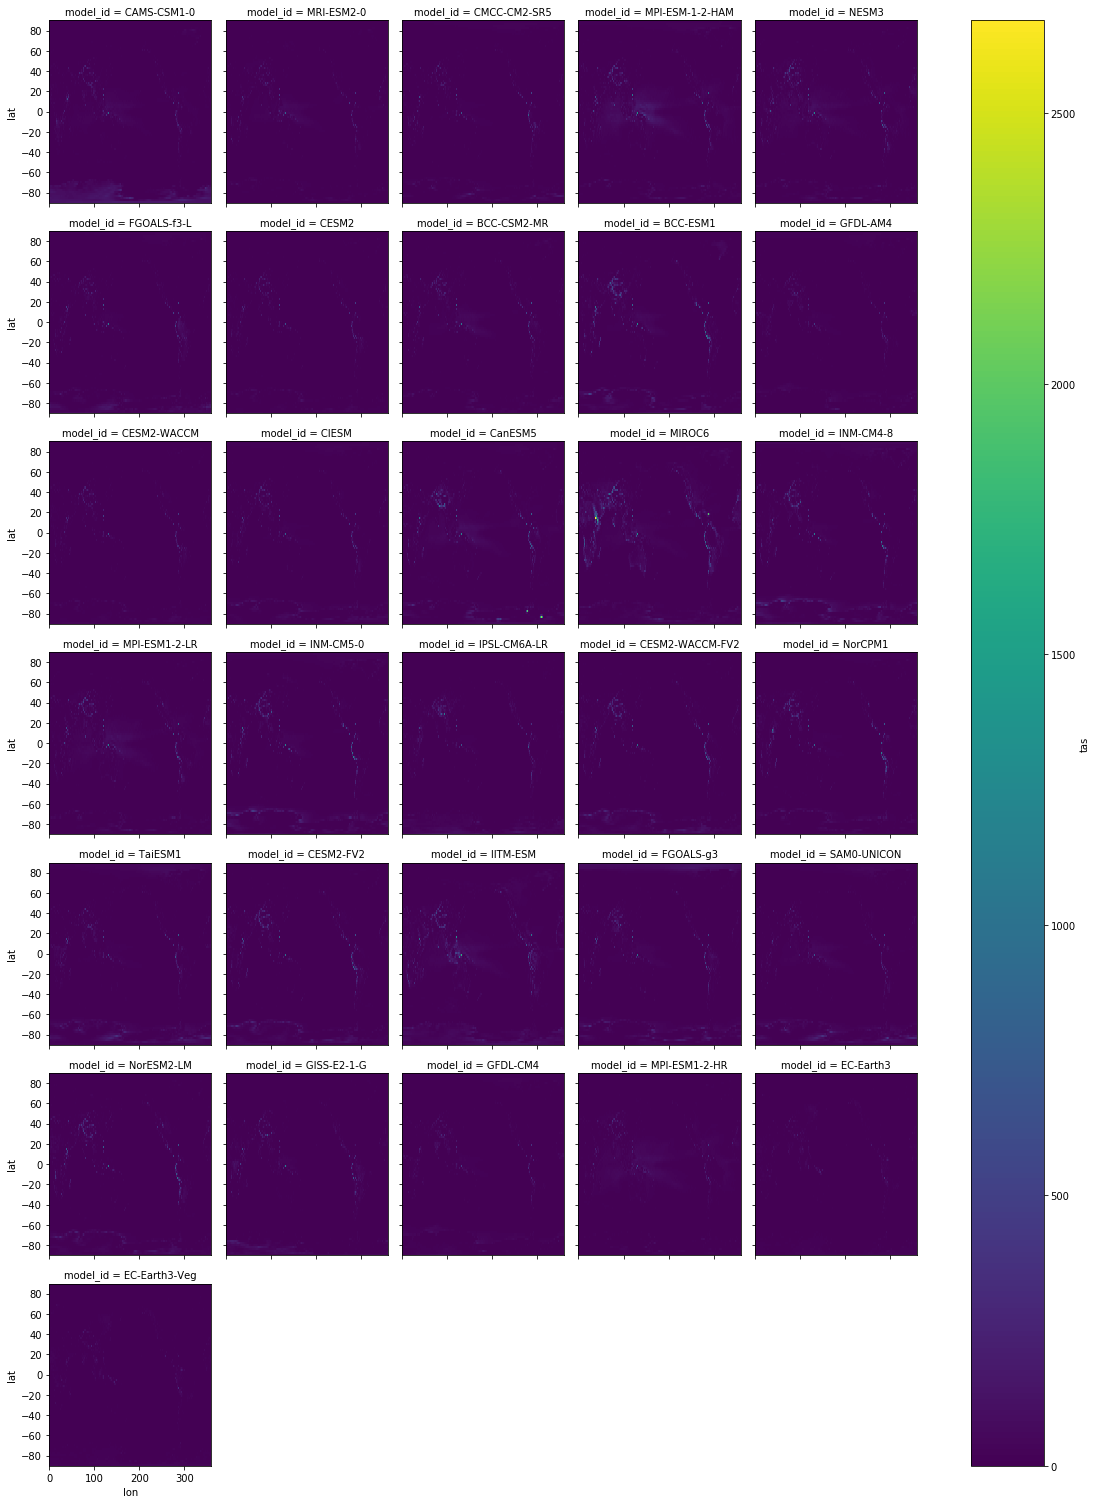

In [51]:
output_2d.tas.plot(x='lon',y='lat', col='model_id', col_wrap=5)

Now we have to do the correct area weighted sum: 
https://pangeo.io/use_cases/physical-oceanography/sea-surface-height.html#timeseries-of-global-mean-sea-level

This seems reasonable, so I will use this example: https://github.com/swartn/cmip6-gmst-anoms/blob/master/gmst_cmip6.ipynb

Using the iris package could also be a possibility to do this in the future

### Fieldsum


In [52]:
coslat_2d = np.cos(np.deg2rad(output_2d['lat'])) * xr.ones_like(output_2d['lon'])
coslat = np.cos(np.deg2rad(output_2d.lat))

e2_cmip6_2d = ((output_2d * coslat_2d).sum(dim=['lat', 'lon']))/coslat_2d.sum(dim=['lat','lon'])

e2_cmip6_3d = ( ((output_3d * coslat).sum(dim='lat')) / coslat.sum(dim='lat') ).mean(dim='plev')

e2_cmip6 = xr.merge([e2_cmip6_2d, e2_cmip6_3d])

e2_cmip6 = e2_cmip6.compute()

In [53]:
#Only tropics:
coslat_2d_tropics = coslat_2d.sel(lat=slice(-30,30))
coslat_tropics = coslat.sel(lat=slice(-30,30))

e2_cmip6_2d_tropics = ((output_2d.sel(lat=slice(-30,30)) * coslat_2d_tropics).sum(dim=['lat', 'lon'])) / coslat_2d_tropics.sum(dim=['lat','lon'])

e2_cmip6_3d_tropics = ( ((output_3d.sel(lat=slice(-30,30)) * coslat_tropics).sum(dim='lat')) / coslat_tropics.sum(dim='lat') ).mean(dim='plev')

e2_cmip6_tropics = xr.merge([e2_cmip6_2d_tropics, e2_cmip6_3d_tropics])

e2_cmip6_tropics = e2_cmip6_tropics.compute()

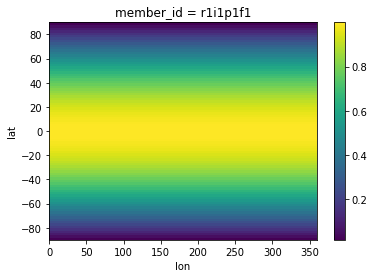

In [54]:
coslat_2d.plot(x='lon',y='lat')

In [55]:
e2_cmip6_2d.ps.load()

<xarray.DataArray 'ps' (model_id: 31)>
array([1116.34924338,  998.88485441, 1439.62003668, 1960.54535457,
       1962.80280919, 1077.43604602, 1245.01109209, 1865.54601914,
       4380.62260871,  963.09511129, 1246.37014821, 1591.21726676,
       2820.54504809, 1949.15084365, 2760.70984258, 1962.48669564,
       2764.15583072, 1610.53533557, 2900.96045749, 3416.70818372,
       1439.5363781 , 2899.25031003, 2178.69583323, 1727.88713857,
       1444.16416506, 2909.27575885, 1388.67532981,  963.07984064,
        861.8350675 ,  526.99190629,  526.90776736])
Coordinates:
    member_id  <U8 'r1i1p1f1'
  * model_id   (model_id) <U15 'CAMS-CSM1-0' 'MRI-ESM2-0' ... 'EC-Earth3-Veg'

Write out the file:

In [56]:
TARGET_DIR = "../data/icon-param-exp/skill_score"
outfile = "cmip6_e2_all.nc"
outfile_tropics = "cmip6_e2_all_tropics.nc"


e2_cmip6.to_netcdf(TARGET_DIR + "/" + outfile)

e2_cmip6_tropics.to_netcdf(TARGET_DIR + "/" + outfile_tropics)



## Jump here if you don't want to do the rest of the calculation

In [57]:
TARGET_DIR = "../data/icon-param-exp/skill_score"
outfile = "cmip6_e2_all.nc"
outfile_tropics = "cmip6_e2_all_tropics.nc"


read_back_in = True

if read_back_in == True :
    e2_cmip6 = xr.open_dataset(TARGET_DIR + "/" + outfile)
    e2_cmip6_tropics = xr.open_dataset(TARGET_DIR + "/" + outfile_tropics)

e2_cmip6

<xarray.Dataset>
Dimensions:     (model_id: 31, plev: 11)
Coordinates:
    member_id   object ...
  * plev        (plev) float64 1e+05 8.5e+04 7e+04 6e+04 ... 1.5e+04 1e+04 5e+03
  * model_id    (model_id) object 'CAMS-CSM1-0' 'MRI-ESM2-0' ... 'EC-Earth3-Veg'
Data variables:
    pr          (model_id) float64 ...
    ps          (model_id) float64 ...
    TOA_net_LW  (model_id) float64 ...
    tas         (model_id) float64 ...
    TOA_net_SW  (model_id) float64 ...
    ta          (model_id) float64 ...
    ua          (model_id) float64 ...
    va          (model_id) float64 ...

## Calculation of model averged e^2 
The normalisation factor in equation 2 is defined as the average errror of reference models. The reference models will be CMIP5 models.

In [58]:
e2_cmip6_average = e2_cmip6.mean('model_id')
e2_cmip6_tropics_average = e2_cmip6_tropics.mean('model_id')


e2_cmip6_average

<xarray.Dataset>
Dimensions:     (plev: 11)
Coordinates:
    member_id   <U8 'r1i1p1f1'
  * plev        (plev) float64 1e+05 8.5e+04 7e+04 6e+04 ... 1.5e+04 1e+04 5e+03
Data variables:
    pr          float64 9.133
    ps          float64 1.835e+03
    TOA_net_LW  float64 9.576
    tas         float64 8.602
    TOA_net_SW  float64 24.84
    ta          float64 18.41
    ua          float64 8.918
    va          float64 13.94

## Calculation of the index
This happens for every variable and every model.
Based on equation (2)

In [59]:
I2_cmip6 = e2_cmip6 / e2_cmip6_average
I2_cmip6_tropics = e2_cmip6_tropics / e2_cmip6_tropics_average


I2_cmip6

<xarray.Dataset>
Dimensions:     (model_id: 31, plev: 11)
Coordinates:
    member_id   <U8 'r1i1p1f1'
  * plev        (plev) float64 1e+05 8.5e+04 7e+04 6e+04 ... 1.5e+04 1e+04 5e+03
  * model_id    (model_id) object 'CAMS-CSM1-0' 'MRI-ESM2-0' ... 'EC-Earth3-Veg'
Data variables:
    pr          (model_id) float64 1.237 0.4537 0.7925 ... 0.4594 0.1653 0.1652
    ps          (model_id) float64 0.6082 0.5442 0.7843 ... 0.4695 0.2871 0.2871
    TOA_net_LW  (model_id) float64 1.039 0.3979 0.5023 ... 0.3801 0.357 0.3619
    tas         (model_id) float64 1.096 0.7503 0.6237 ... 1.367 0.3947 0.3917
    TOA_net_SW  (model_id) float64 3.354 0.4112 1.416 ... 0.5963 0.5703 0.5625
    ta          (model_id) float64 0.6465 0.6092 0.7244 ... 0.3505 0.4319 0.4367
    ua          (model_id) float64 1.153 0.6861 0.4531 ... 0.2737 0.1773 0.168
    va          (model_id) float64 0.5982 1.017 0.5571 ... 0.6031 0.1717 0.1657

### Averaged index over all variables

In [60]:
# change variables to coordinates:
list_of_arrays=[]
final_vars=['pr','ps','TOA_net_LW','TOA_net_SW','tas','ta','ua','va']
for var in final_vars :
    data_array = I2_cmip6[var]
    list_of_arrays.append(data_array.compute())

#create new dimension variable
index_vars_ar = xr.DataArray(final_vars[:], name='output_var', dims='output_var')

#make new Data Array for whole ensemble
I2_cmip6_final = xr.concat(list_of_arrays, index_vars_ar).to_dataset(name='index')

I2_var_mean_cmip6 = I2_cmip6_final.mean('output_var')
I2_cmip6_final

<xarray.Dataset>
Dimensions:     (model_id: 31, output_var: 8)
Coordinates:
    member_id   <U8 'r1i1p1f1'
  * model_id    (model_id) object 'CAMS-CSM1-0' 'MRI-ESM2-0' ... 'EC-Earth3-Veg'
  * output_var  (output_var) <U10 'pr' 'ps' 'TOA_net_LW' ... 'ta' 'ua' 'va'
Data variables:
    index       (output_var, model_id) float64 1.237 0.4537 ... 0.1717 0.1657

In [61]:
list_of_arrays=[]
for var in final_vars :
    data_array = I2_cmip6_tropics[var]
    list_of_arrays.append(data_array.compute())

#make new Data Array for whole ensemble
I2_cmip6_tropics_final = xr.concat(list_of_arrays, index_vars_ar).to_dataset(name='index')

I2_var_mean_cmip6_tropics = I2_cmip6_tropics_final.mean('output_var')
I2_cmip6_tropics_final

<xarray.Dataset>
Dimensions:     (model_id: 31, output_var: 8)
Coordinates:
    member_id   <U8 'r1i1p1f1'
  * model_id    (model_id) object 'CAMS-CSM1-0' 'MRI-ESM2-0' ... 'EC-Earth3-Veg'
  * output_var  (output_var) <U10 'pr' 'ps' 'TOA_net_LW' ... 'ta' 'ua' 'va'
Data variables:
    index       (output_var, model_id) float64 0.9425 0.4989 ... 0.2322 0.2271

# ICON-A experiments
raw data stored in

/work/mh0066/m300577/icon-aes/experiments/

processed data stored in

/work/mh0066/m300577/icon-param-exp/skill_score

In [62]:
DATA_DIR = "../data/icon-aes/experiments"

# update this when doing more experiments
members=['ppk0002', 'ppk0010', 'ppk0011', 'ppk0012', 'ppk0013', 'ppk0022','ppk0023','ppk0024','ppk0025','ppk0026','ppk0027']

levels

[100000, 85000, 70000, 60000, 50000, 30000, 25000, 20000, 15000, 10000, 5000]

## preprocess with cdos:
- timemean
- spatial interpolation (Linear interpolation does not work for unstructered grids in cdo, instead we do do distance-weighted average interpolation)
- 3d vars also need to be vertically interpolated


In [63]:
preproc_2d = False
preproc_3d = False

Get data, do timemean

In [64]:

TEMP_DIR = "/scratch/m/m300577/skill_score"

if preproc_2d == True :
    #2d:
    for memb in members :
        print("\n" + memb)

        infile = DATA_DIR + "/" + memb + "/" + memb + "_atm_2d_ml_????0101T000000Z.nc"
        outfile = TARGET_DIR + "/" + memb + "_atm_2d_ym.nc"
        #!ls $infile
        !rm -f $outfile
        !cdo remapdis,global_2 -yearmean -cat $infile $outfile


Get data, do timemean and do horizontal interpolation. Then merge the two datasets (so that surface pressure is available) and do the vertical interpolation of the 3d data.

In [65]:
# we need to give bash the vertical levels as a string.
# Somewow one "1" gets lost along the way so we have to out two "1" at the beginning...


levels_bash = '1100000,85000,70000,60000,50000,30000,25000,20000,15000,10000,5000'


if preproc_3d == True :
    for memb in members :
        
        print("\n" + memb)
        
        infile = DATA_DIR + "/" + memb + "/" + memb + "_atm_3d_ml_????0101T000000Z.nc"
        outfile1 = TARGET_DIR + "/" + memb + "_atm_3d_ym.nc"
        !rm -f $outfile1

        !cdo remapdis,global_2 -yearmean -selname,ua,va,ta,pfull -cat $infile $outfile1
        
        !echo ${levels_bash}
        
        file_2d = TARGET_DIR + "/" + memb + "_atm_2d_ym.nc"
        final_outfile = TARGET_DIR + "/" + memb + "_atm_2d+ua_va_ta_ym.nc"

        !rm -f $final_outfile
        !cdo ap2pl,${levels_bash} -merge $outfile1 $file_2d $final_outfile


!ls $TARGET_DIR

cmip5_e2_all.nc		       ppk0034_atm_2d+ua_va_ta_ym.nc
cmip5_e2_all_tropics.nc        ppk0034_atm_2d_ym.nc
cmip6_e2_all.nc		       ppk0034_atm_3d_ym.nc
cmip6_e2_all_tropics.nc        ppk0035_atm_2d+ua_va_ta_ym.nc
ppk0002_atm_2d_timmean.nc      ppk0035_atm_2d_ym.nc
ppk0002_atm_2d+ua_va_ta_ym.nc  ppk0035_atm_3d_ym.nc
ppk0002_atm_2d_ym.nc	       ppk0040_atm_2d+ua_va_ta_ym.nc
ppk0002_atm_3d_timmean.nc      ppk0040_atm_2d_ym.nc
ppk0002_atm_3d_ua_va_ta_ym.nc  ppk0040_atm_3d_ym.nc
ppk0002_atm_3d_ym.nc	       ppk0041_atm_2d+ua_va_ta_ym.nc
ppk0010_atm_2d_timmean.nc      ppk0041_atm_2d_ym.nc
ppk0010_atm_2d+ua_va_ta_ym.nc  ppk0041_atm_3d_ym.nc
ppk0010_atm_2d_ym.nc	       ppk0042_atm_2d+ua_va_ta_ym.nc
ppk0010_atm_3d_timmean.nc      ppk0042_atm_2d_ym.nc
ppk0010_atm_3d_ua_va_ta_ym.nc  ppk0042_atm_3d_ym.nc
ppk0010_atm_3d_ym.nc	       ppk0043_atm_2d+ua_va_ta_ym.nc
ppk0011_atm_2d_timmean.nc      ppk0043_atm_2d_ym.nc
ppk0011_atm_2d+ua_va_ta_ym.nc  ppk0043_atm_3d_ym.nc
ppk0011_atm_2d_ym.nc	       ppk0044_

## Read files

In [66]:
# open files:
# we can preprocess the data with the preproc function
# especially important is the assignment of a newcoordinate that 
# describes ensemble members
def preproc(ds):
    filename = ds.encoding['source']
    member=filename[48:55]
    #member is always at the same place in the filename, as long as the data is not moved
    #ds = ds.squeeze(drop='true').drop('time_bnds')
    #ds.coords['lon'] = 
    ds.coords['time'] = np.round(ds.time.values / 10000)
    ds['member'] = member
    return ds

data = xr.open_mfdataset( TARGET_DIR + '/ppk00*_atm_2d+ua_va_ta_ym.nc'
                       ,concat_dim='member',combine='nested', parallel=True, preprocess=preproc)


In [67]:
data

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lon: 180, member: 54, plev: 11, time: 37)
Coordinates:
  * time       (time) float64 1.979e+03 1.98e+03 ... 2.014e+03 2.015e+03
  * lon        (lon) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 6e+04 ... 1.5e+04 1e+04 5e+03
  * member     (member) object 'ppk0002' 'ppk0010' ... 'ppk0073' 'ppk0074'
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (member, time, bnds) float64 dask.array<chunksize=(1, 37, 2), meta=np.ndarray>
    pfull      (member, time, plev, lat, lon) float32 dask.array<chunksize=(1, 37, 11, 90, 180), meta=np.ndarray>
    ta         (member, time, plev, lat, lon) float32 dask.array<chunksize=(1, 37, 11, 90, 180), meta=np.ndarray>
    ua         (member, time, plev, lat, lon) float32 dask.array<chunksize=(1, 37, 11, 90, 180), meta=np.ndarray>
    va         (member, time, plev, lat, lon) float32 dask.array<chunksize=(1, 37, 11, 90, 180), meta=np.ndarray>
    ps         (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    psl        (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    cosmu0     (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    rsdt       (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    rsut       (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    rsutcs     (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    rlut       (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    rlutcs     (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    rsds       (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    rsdscs     (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    rlds       (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    rldscs     (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    rsus       (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    rsuscs     (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    rlus       (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    ts         (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    sic        (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    sit        (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    albedo     (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    clt        (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    prlr       (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    prls       (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    prcr       (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    prcs       (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    pr         (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    prw        (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    cllvi      (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndarray>
    clivi      (member, time, lat, lon) float32 dask.array<chunksize=(1, 37, 90, 180), meta=np.ndar

## More interpolation to get same grid

In [68]:
# define ouptut grid
ds_out = xr.Dataset({
                    'lat': (['lat'], np.arange(-89, 90, 2.0)),
                    'lon': (['lon'], np.arange(1, 360, 2.0)),
                    }
                    )

# xesfm needs to have dimensions in certain order
data_=data.drop_dims('bnds').transpose('member', 'time','plev', 'lat', 'lon')

regridder = xe.Regridder(data_, ds_out, 'bilinear', periodic=True, reuse_weights=True)
regridder._grid_in = None
regridder._grid_out = None

data_interpol_xe = regridder(data_)

Reuse existing file: bilinear_90x180_90x180_peri.nc
using dimensions ('lat', 'lon') from data variable pfull as the horizontal dimensions for this dataset.


/home/mpim/m300577/.local/lib/python3.6/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


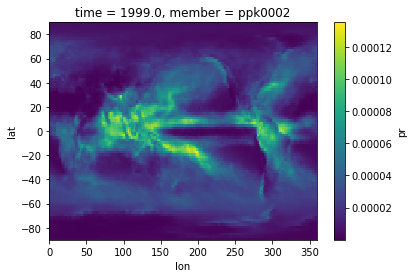

In [69]:
data = data_interpol_xe
data_interpol_xe.sel(time=1999,member='ppk0002').pr.plot(x='lon',y='lat')


In [70]:
icon_param_2d = data[vars_2d].sel(time=slice(1979,2008)).mean('time').rename(rlut='TOA_net_LW')
icon_param_3d = data[vars_3d].sel(time=slice(1979,2008)).mean('time')

# calcualte TOA SW:
icon_param_2d['TOA_net_SW'] = icon_param_2d.rsdt - icon_param_2d.rsut



## zonal means of 3d vars

In [71]:
icon_param_3d_zonmean = icon_param_3d.mean('lon')

## Calculation of e^2 (equation 1)


In [72]:
era5_2d_timemean

<xarray.Dataset>
Dimensions:     (lat: 90, lon: 180)
Coordinates:
  * lon         (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * lat         (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Data variables:
    tas         (lat, lon) float64 228.0 228.0 228.0 228.0 ... 259.2 259.2 259.2
    ps          (lat, lon) float64 6.95e+04 6.946e+04 ... 1.014e+05 1.014e+05
    SI          (lat, lon) float64 1.493e+07 1.493e+07 ... 1.482e+07 1.482e+07
    TOA_net_SW  (lat, lon) float64 48.78 48.78 48.77 48.77 ... 68.66 68.66 68.67
    TOA_net_LW  (lat, lon) float64 146.5 146.4 146.4 146.4 ... 193.5 193.5 193.5
    pr          (lat, lon) float64 1.803e-06 1.8e-06 ... 8.056e-06 8.069e-06

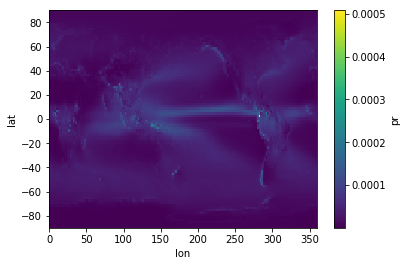

In [73]:
era5_2d_timemean.pr.plot(x='lon',y='lat')

In [74]:
icon_param_2d

<xarray.Dataset>
Dimensions:     (lat: 90, lon: 180, member: 54)
Coordinates:
  * member      (member) object 'ppk0002' 'ppk0010' ... 'ppk0073' 'ppk0074'
  * lon         (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * lat         (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Data variables:
    ps          (member, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    rsdt        (member, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    rsut        (member, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    TOA_net_LW  (member, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    pr          (member, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    tas         (member, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    TOA_net_SW  (member, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>

In [75]:
difference = icon_param_2d - era5_2d_timemean
output_2d = np.square( difference / era5_2d_std )
print(output_2d.compute())

difference = icon_param_3d_zonmean - era5_3d_timemean
output_3d = np.square( difference / era5_3d_std )

<xarray.Dataset>
Dimensions:     (lat: 90, lon: 180, member: 54)
Coordinates:
  * member      (member) object 'ppk0002' 'ppk0010' ... 'ppk0073' 'ppk0074'
  * lon         (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * lat         (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Data variables:
    ps          (member, lat, lon) float64 2.609 1.992 1.626 ... 5.469 5.498
    TOA_net_LW  (member, lat, lon) float64 13.27 13.09 12.93 ... 61.29 61.17
    pr          (member, lat, lon) float64 2.589 2.604 2.594 ... 3.907 3.957
    tas         (member, lat, lon) float64 10.15 9.932 9.687 ... 2.453 2.425
    TOA_net_SW  (member, lat, lon) float64 3.343 3.361 3.385 ... 87.14 89.25


In [76]:
coslat = np.cos(np.deg2rad(output_2d.lat))
coslat_2d = np.cos(np.deg2rad(output_2d['lat'])) * xr.ones_like(output_2d['lon'])
coslat_2d_tropics = coslat_2d.sel(lat=slice(-30,30))
coslat_tropics = coslat.sel(lat=slice(-30,30))

e2_icon_2d = ((output_2d * coslat_2d).sum(dim=['lat', 'lon'])) / coslat_2d.sum(dim=['lat','lon'])
e2_icon_2d = e2_icon_2d.compute()


e2_icon_2d_tropics = ((output_2d.sel(lat=slice(-30,30)) * coslat_2d_tropics)).sum(dim=['lat', 'lon']) / coslat_2d_tropics.sum(dim=['lat','lon'])
e2_icon_2d_tropics = e2_icon_2d_tropics.compute()


In [77]:
e2_icon_3d = (((output_3d * coslat).sum(dim='lat')) / coslat.sum(dim='lat')).mean(dim='plev')
e2_icon_3d = e2_icon_3d.compute()

e2_icon_3d_tropics = (((output_3d.sel(lat=slice(-30,30)) * coslat_tropics).sum(dim='lat')) / coslat_tropics.sum(dim='lat')).mean(dim='plev')
e2_icon_3d_tropics = e2_icon_3d_tropics.compute()

e2_icon_tropics = xr.merge([e2_icon_2d_tropics, e2_icon_3d_tropics])


In [78]:
e2_icon = xr.merge([e2_icon_2d, e2_icon_3d])
e2_icon_tropics = xr.merge([e2_icon_2d_tropics, e2_icon_3d_tropics])


## Calculation of the index
This happens for every variable and every model.
Based on equation (2)

In [79]:
I2_icon = e2_icon / e2_cmip6_average
I2_icon_tropics = e2_icon_tropics/ e2_cmip6_tropics_average

In [80]:
I2_icon.tas.load()

<xarray.DataArray 'tas' (member: 54)>
array([0.89101028, 0.95472004, 0.92634348, 0.81891014, 0.82236828,
       0.90224377, 0.8779871 , 0.88389155, 0.90793459, 0.8592792 ,
       0.92913547, 0.87768435, 1.44503241, 0.86467116, 1.25373707,
       1.81303342, 0.83661761, 0.88789172, 0.89402541, 0.90111892,
       0.88979341, 0.8912676 , 0.88326917, 0.87171024, 1.80926452,
       0.92427858, 0.86442597, 0.87657124, 0.86472378, 0.83551752,
       0.99109328, 0.98214952, 0.97972364, 1.00227821, 0.98230289,
       0.83178066, 0.82676786, 0.81531398, 0.81621532, 0.9049577 ,
       0.88766221, 0.89241463, 0.89802816, 0.90566682, 1.51818897,
       1.5102239 , 1.51359981, 1.51852176, 1.50912804, 0.96887358,
       0.96598135, 0.97110698, 0.96138614, 0.96082307])
Coordinates:
  * member     (member) object 'ppk0002' 'ppk0010' ... 'ppk0073' 'ppk0074'
    member_id  <U8 'r1i1p1f1'

### Averaged index over all variables

In [81]:
# change variables to coordinates:
list_of_arrays=[]
final_vars=['pr','ps','TOA_net_LW','TOA_net_SW','tas','ta','ua','va']
for var in final_vars :
    data_array = I2_icon[var]
    list_of_arrays.append(data_array.compute())

#create new dimension variable
index_vars_ar = xr.DataArray(final_vars[:], name='output_var', dims='output_var')

#make new Data Array for whole ensemble
I2_icon_final = xr.concat(list_of_arrays, index_vars_ar).to_dataset(name='index')

I2_var_mean_icon = I2_icon_final.mean('output_var')
I2_var_mean_icon

<xarray.Dataset>
Dimensions:    (member: 54)
Coordinates:
  * member     (member) object 'ppk0002' 'ppk0010' ... 'ppk0073' 'ppk0074'
    member_id  <U8 'r1i1p1f1'
Data variables:
    index      (member) float64 1.084 1.032 1.044 1.301 ... 1.355 1.345 1.342

In [82]:
# change variables to coordinates:
list_of_arrays=[]

for var in final_vars :
    data_array = I2_icon_tropics[var]
    list_of_arrays.append(data_array.compute())

#make new Data Array for whole ensemble
I2_icon_final_tropics = xr.concat(list_of_arrays, index_vars_ar).to_dataset(name='index')

I2_var_mean_icon_tropics = I2_icon_final_tropics.mean('output_var')
I2_var_mean_icon_tropics

<xarray.Dataset>
Dimensions:    (member: 54)
Coordinates:
  * member     (member) object 'ppk0002' 'ppk0010' ... 'ppk0073' 'ppk0074'
    member_id  <U8 'r1i1p1f1'
Data variables:
    index      (member) float64 0.8629 0.8648 0.8645 1.045 ... 1.076 1.068 1.066

## Organise data

In [83]:
I2_icon_cprcon = I2_icon_final.sel(member=['ppk0002','ppk0010','ppk0011','ppk0012','ppk0013'])
I2_icon_entrpen = I2_icon_final.sel(member=['ppk0002','ppk0022','ppk0023','ppk0024','ppk0025'])
I2_icon_both = I2_icon_final.sel(member=['ppk0026','ppk0027'])

I2_icon_cprcon_tropics = I2_icon_final_tropics.sel(member=['ppk0002','ppk0010','ppk0011','ppk0012','ppk0013'])
I2_icon_entrpen_tropics = I2_icon_final_tropics.sel(member=['ppk0002','ppk0022','ppk0023','ppk0024','ppk0025'])
I2_icon_both_tropics = I2_icon_final_tropics.sel(member=['ppk0026','ppk0027'])

cprcon_values = xr.DataArray([0.00025,0.0005,0.0004,0.0001,0.00005], coords = [I2_icon_cprcon.member], dims='member')
I2_icon_cprcon['cprcon_values']=cprcon_values
I2_icon_cprcon_tropics['cprcon_values']=cprcon_values

entrpen_values = xr.DataArray([0.0002,0.0006,0.00005,0.000375,0.0001], coords = [I2_icon_entrpen.member], dims='member')
I2_icon_entrpen['entrpen_values']=entrpen_values
I2_icon_entrpen_tropics['entrpen_values']=entrpen_values


In [84]:
reference_members = ['ppk0002','ppk0030','ppk0031','ppk0032','ppk0033','ppk0034','ppk0035']
high_entrpen_members = ['ppk0060','ppk0061','ppk0062','ppk0063','ppk0064']
low_entrpen_members = ['ppk0065','ppk0066','ppk0067','ppk0068','ppk0069']
high_cprcon_members = ['ppk0013','ppk0055','ppk0056','ppk0057','ppk0058']
low_cprcon_members = ['ppk0050','ppk0051','ppk0052','ppk0053','ppk0054']
very_high_entrpen_members = ['ppk0070','ppk0071','ppk0072','ppk0073','ppk0074']

In [85]:
I2_icon_reference = I2_icon_final.sel(member = reference_members).mean('member')

I2_icon_high_entrpen = I2_icon_final.sel(member = high_entrpen_members).mean('member')
I2_icon_very_high_entrpen = I2_icon_final.sel(member = very_high_entrpen_members).mean('member')
I2_icon_low_entrpen = I2_icon_final.sel(member = low_entrpen_members).mean('member')

I2_icon_high_cprcon = I2_icon_final.sel(member = high_cprcon_members).mean('member')
I2_icon_low_cprcon = I2_icon_final.sel(member = low_cprcon_members).mean('member')

#tropics:
I2_icon_reference_tropics = I2_icon_final_tropics.sel(member = reference_members).mean('member')

I2_icon_high_entrpen_tropics = I2_icon_final_tropics.sel(member = high_entrpen_members).mean('member')
I2_icon_very_high_entrpen_tropics = I2_icon_final_tropics.sel(member = very_high_entrpen_members).mean('member')
I2_icon_low_entrpen_tropics = I2_icon_final_tropics.sel(member = low_entrpen_members).mean('member')

I2_icon_high_cprcon_tropics = I2_icon_final_tropics.sel(member = high_cprcon_members).mean('member')
I2_icon_low_cprcon_tropics = I2_icon_final_tropics.sel(member = low_cprcon_members).mean('member')



# Plot results

In [86]:
import matplotlib.colors as mcolors


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

minColor = 0.3
maxColor = 0.95
purples_t = truncate_colormap(plt.get_cmap("Purples"), minColor, maxColor)
reds_t = truncate_colormap(plt.get_cmap("OrRd"), minColor, maxColor)

In [87]:
def remove_axes(ax) :
    spines_to_keep = ['left', 'bottom']     
    for spine in spines_to_keep:
        ax.spines[spine].set_linewidth(0.5)
    spines_to_remove = ['top', 'right'] 
    for spine in spines_to_remove:
        ax.spines[spine].set_visible(False)

In [88]:
plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'figure.autolayout': True})

/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


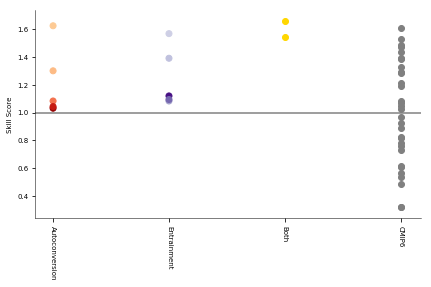

In [89]:

I2_cmip6_values = I2_var_mean_cmip6.index.values
cmip6_dummy_list = ['CMIP6'] * len(I2_cmip6_values)
cprcon_dummy_list = ['Autoconversion'] * len(I2_icon_cprcon.mean('output_var').index.values)
entrpen_dummy_list = ['Entrainment'] * len(I2_icon_entrpen.mean('output_var').index.values)
both_dummy_list = ['Both'] * len(I2_icon_both.mean('output_var').index.values)

fig, ax = plt.subplots(facecolor='white')

ax.scatter(x=cprcon_dummy_list,y=I2_icon_cprcon.mean('output_var').index.values,c=I2_icon_cprcon.cprcon_values.values,cmap=reds_t)
ax.scatter(x=entrpen_dummy_list,y=I2_icon_entrpen.mean('output_var').index.values,c=I2_icon_entrpen.entrpen_values.values,cmap=purples_t)
ax.scatter(x=both_dummy_list,y=I2_icon_both.mean('output_var').index.values,color='gold')

ax.scatter(cmip6_dummy_list, I2_cmip6_values,color='grey')
ax.axhline(y=1,color='grey')

ax.set_ylabel('Skill Score')

plt.xticks(rotation=270)

remove_axes(ax)


plt.savefig('../plots/icon_param_skill_score.pdf', dpi=600)



/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


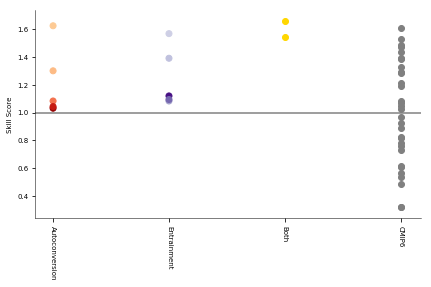

In [90]:

I2_cmip6_values = I2_var_mean_cmip6.index.values
cmip6_dummy = ['cmip6'] * len(I2_cmip6_values)
cprcon_dummy = ['Autoconversion'] * len(I2_icon_cprcon.mean('output_var').index.values)
entrpen_dummy_list = ['Entrainment'] * len(I2_icon_entrpen.mean('output_var').index.values)
both_dummy_list = ['Both'] * len(I2_icon_both.mean('output_var').index.values)

fig, ax = plt.subplots(facecolor='white')

ax.scatter(x=cprcon_dummy_list,y=I2_icon_cprcon.mean('output_var').index.values,c=I2_icon_cprcon.cprcon_values.values,cmap=reds_t)
ax.scatter(x=entrpen_dummy_list,y=I2_icon_entrpen.mean('output_var').index.values,c=I2_icon_entrpen.entrpen_values.values,cmap=purples_t)
ax.scatter(x=both_dummy_list,y=I2_icon_both.mean('output_var').index.values,color='gold')

ax.scatter(cmip6_dummy_list, I2_cmip6_values,color='grey')
ax.axhline(y=1,color='grey')

ax.set_ylabel('Skill Score')

plt.xticks(rotation=270)

remove_axes(ax)


/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


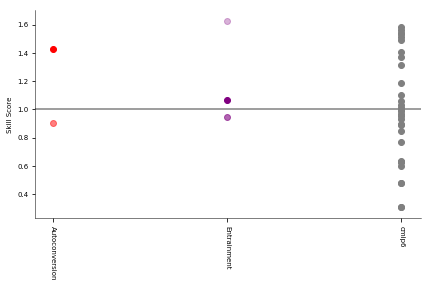

In [91]:

I2_cmip6_values_tropics = I2_var_mean_cmip6_tropics.index.values
cmip6_dummy_list = ['cmip6'] * len(I2_cmip6_values_tropics)
cprcon_dummy_list = ['Autoconversion'] * len(I2_icon_cprcon_tropics.mean('output_var').index.values)
entrpen_dummy_list = ['Entrainment'] * len(I2_icon_entrpen_tropics.mean('output_var').index.values)
both_dummy_list = ['Both'] * len(I2_icon_both_tropics.mean('output_var').index.values)

fig, ax = plt.subplots(facecolor='white')

ax.scatter(x='Autoconversion',y=I2_icon_low_cprcon_tropics.mean('output_var').index.values,alpha=0.5,color='red')
ax.scatter(x='Autoconversion',y=I2_icon_high_cprcon_tropics.mean('output_var').index.values,color='red')
ax.scatter(x='Entrainment',y=I2_icon_very_high_entrpen_tropics.mean('output_var').index.values,color='purple')
ax.scatter(x='Entrainment',y=I2_icon_high_entrpen_tropics.mean('output_var').index.values,color='purple',alpha=0.6)
ax.scatter(x='Entrainment',y=I2_icon_low_entrpen_tropics.mean('output_var').index.values,color='purple',alpha=0.3)

ax.scatter(cmip6_dummy_list, I2_cmip6_values_tropics,color='grey')
ax.axhline(y=1,color='grey')

ax.set_ylabel('Skill Score')

plt.xticks(rotation=270)

remove_axes(ax)


No handles with labels found to put in legend.


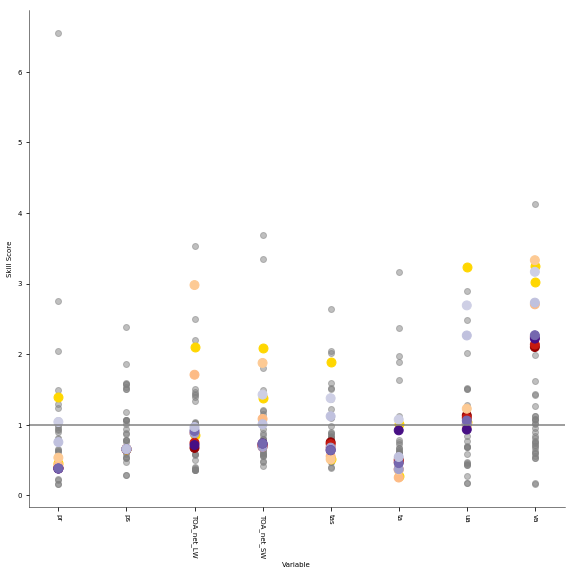

In [92]:

variables = I2_icon_cprcon_tropics.output_var.values

fig, ax = plt.subplots(figsize=((8,8)), facecolor='white')
I2_cmip6_final.plot.scatter(x='output_var',y='index',alpha = 0.5, color='grey')

for var in variables :
    var_dummy = [var] * 5
    var_dummy_both = [var] * 2
    ax.scatter(x=var_dummy_both,y=I2_icon_both_tropics.sel(output_var=var).index.values,color='gold',s=80)
    ax.scatter(x=var_dummy,y=I2_icon_cprcon_tropics.sel(output_var=var).index.values,c=I2_icon_cprcon.cprcon_values.values,cmap=reds_t,s=80)
    ax.scatter(x=var_dummy,y=I2_icon_entrpen_tropics.sel(output_var=var).index.values,c=I2_icon_entrpen.entrpen_values.values,cmap=purples_t,s=80)


ax.axhline(y=1,color='grey')
ax.set_ylabel('Skill Score')
ax.set_xlabel('Variable')


plt.xticks(rotation=270)
ax.legend().remove()

remove_axes(ax)


/home/mpim/m300577/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


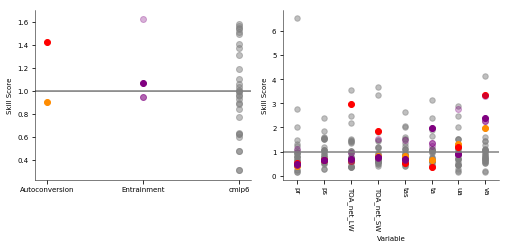

In [98]:
I2_cmip6_values_tropics = I2_var_mean_cmip6_tropics.index.values
cmip6_dummy_list = ['cmip6'] * len(I2_cmip6_values_tropics)
cprcon_dummy_list = ['Autoconversion'] * len(I2_icon_cprcon_tropics.mean('output_var').index.values)
entrpen_dummy_list = ['Entrainment'] * len(I2_icon_entrpen_tropics.mean('output_var').index.values)
both_dummy_list = ['Both'] * len(I2_icon_both_tropics.mean('output_var').index.values)


fig, axes = plt.subplots(1,2, figsize=(18/2.54,8.8/2.54),facecolor='w')

ax=axes[0]

ax.axhline(y=1,color='grey',linewidth=0.5)

ax.scatter(x='Autoconversion',y=I2_icon_low_cprcon_tropics.mean('output_var').index.values,color='darkorange')
ax.scatter(x='Autoconversion',y=I2_icon_high_cprcon_tropics.mean('output_var').index.values,color='red')
ax.scatter(x='Entrainment',y=I2_icon_very_high_entrpen_tropics.mean('output_var').index.values,color='purple')
ax.scatter(x='Entrainment',y=I2_icon_high_entrpen_tropics.mean('output_var').index.values,color='purple',alpha=0.6)
ax.scatter(x='Entrainment',y=I2_icon_low_entrpen_tropics.mean('output_var').index.values,color='purple',alpha=0.3)


ax.scatter(cmip6_dummy_list, I2_cmip6_values_tropics,color='grey',alpha = 0.5)
ax.axhline(y=1,color='grey')

ax.set_ylabel('Skill Score')

plt.xticks(rotation=270)

remove_axes(ax)


ax=axes[1]


I2_cmip6_final.plot.scatter(x='output_var',y='index',alpha = 0.5, color='grey',s=30)

for var in variables :
    var_dummy = var
    ax.scatter(x=var_dummy,y=I2_icon_low_cprcon_tropics.sel(output_var=var).index.values,color='darkorange')
    ax.scatter(x=var,y=I2_icon_high_cprcon_tropics.sel(output_var=var).index.values,color='red')
    ax.scatter(x=var,y=I2_icon_very_high_entrpen_tropics.sel(output_var=var).index.values,color='purple')
    ax.scatter(x=var,y=I2_icon_high_entrpen_tropics.sel(output_var=var).index.values,color='purple',alpha=0.6)
    ax.scatter(x=var,y=I2_icon_low_entrpen_tropics.sel(output_var=var).index.values,color='purple',alpha=0.3)

    

ax.axhline(y=1,color='grey')
ax.set_ylabel('Skill Score')
ax.set_xlabel('Variable')


plt.xticks(rotation=270)


remove_axes(ax)

plt.savefig('../plots/icon_param_skill_score_all_tropics.pdf', dpi=600)
